In [40]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### データ読込

In [41]:
in_dir = '../data/two_years_each/val_1/consistent'

df_train_X = pd.read_excel(os.path.join(in_dir, 'train_X.xlsx'), header=0, index_col=0)
df_train_Y = pd.read_excel(os.path.join(in_dir, 'train_Y.xlsx'), header=0, index_col=0)

df_val_X = pd.read_excel(os.path.join(in_dir, 'val_X.xlsx'), header=0, index_col=0)
df_val_Y = pd.read_excel(os.path.join(in_dir, 'val_Y.xlsx'), header=0, index_col=0)

### 目的変数の分布

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

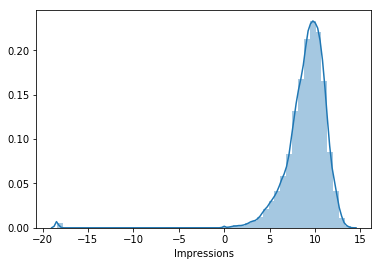

In [42]:
sns.distplot(np.log(df_train_Y['Impressions'] + 0.00000001))
plt.plot()

In [43]:
def log(x):
    return np.log(x + 0.00000001)

#for c in ['Sales', 'Impressions', 'Clicks', 'Cost']:
for c in ['Impressions']:
    df_train_Y['Impressions_log'] = df_train_Y['Impressions'].apply(log)
    df_val_Y['Impressions_log'] = df_val_Y['Impressions'].apply(log)

### データ構造転換

In [44]:
d_train_sales = xgb.DMatrix(df_train_X, label=df_train_Y['Impressions_log'])
d_val_sales = xgb.DMatrix(df_val_X, label=df_val_Y['Impressions_log'])

d_val = xgb.DMatrix(df_val_X)

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### パラメータのベイズ最適化
- 

In [ ]:
def score(params):
    print("Training with params: ")
    print(params)

    evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
    evals_result = {}

    model = xgb.train(params, 
              d_train_sales, 
              num_boost_round=1000, 
              evals=evals,
              early_stopping_rounds=20,
              evals_result=evals_result)
    
    d_pred = np.exp(model.predict(d_val))
    loss = mean_squared_error(d_pred, df_val_Y['Impressions'].values)
    print(f'loss: {loss}')
    return {'loss': loss, 'status': STATUS_OK}

def optimize(random_state=71):
    
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(3, 10, dtype=int)),
        'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
        'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
        'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
        'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
        'lambda': hp.loguniform('lambda', np.log(1e-6), np.log(10.0)),
        'nthread': 4,
        'seed': random_state
    }
    best = fmin(score, space, 
                algo=tpe.suggest, 
                max_evals=250)
    return best
params = optimize()
params

Training with params:                                                                                                  
{'alpha': 0.00020384376974484422, 'colsample_bytree': 0.65, 'gamma': 0.008821009047483879, 'lambda': 1.684818718833148e-06, 'learning_rate': 0.47500000000000003, 'max_depth': 4, 'min_child_weight': 0.18013420050237017, 'n_estimators': 464.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:4.8235	eval-rmse:4.87418                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:2.80933	eval-rmse:2.64866                                                                               

[2]	train-rmse:1.89754	eval-rmse:1.5302                                                                     

[22]	train-rmse:0.896846	eval-rmse:0.69998                                                                             

[23]	train-rmse:0.890951	eval-rmse:0.699854                                                                            

[24]	train-rmse:0.885942	eval-rmse:0.699858                                                                            

[25]	train-rmse:0.876734	eval-rmse:0.702548                                                                            

[26]	train-rmse:0.872225	eval-rmse:0.704798                                                                            

[27]	train-rmse:0.852392	eval-rmse:0.702812                                                                            

[28]	train-rmse:0.843067	eval-rmse:0.712556                                                                            

[29]	train-rmse:0.838045	eval-rmse:0.712733                                                                            

[30]	train-rmse:0.831997	eval-rm

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.25938	eval-rmse:4.25604                                                                               

[2]	train-rmse:3.07504	eval-rmse:2.92873                                                                               

[3]	train-rmse:2.32929	eval-rmse:2.06322                                                                               

[4]	train-rmse:1.89076	eval-rmse:1.4896                                                                                

[5]	train-rmse:1.64498	eval-rmse:1.14532                                                                               

[6]	train-rmse:1.5156	eval-rmse:0.931874                                                                               

[7]	train-rmse:1.44828	eval-rms

[66]	train-rmse:1.21606	eval-rmse:0.642264                                                                             

[67]	train-rmse:1.2143	eval-rmse:0.642253                                                                              

[68]	train-rmse:1.21321	eval-rmse:0.642249                                                                             

[69]	train-rmse:1.21249	eval-rmse:0.642336                                                                             

[70]	train-rmse:1.20391	eval-rmse:0.64559                                                                              

[71]	train-rmse:1.20163	eval-rmse:0.643003                                                                             

[72]	train-rmse:1.20045	eval-rmse:0.642938                                                                             

[73]	train-rmse:1.19918	eval-rmse:0.642955                                                                             

[74]	train-rmse:1.19752	eval-rms

[27]	train-rmse:1.28938	eval-rmse:0.654615                                                                             

[28]	train-rmse:1.28506	eval-rmse:0.652295                                                                             

[29]	train-rmse:1.28298	eval-rmse:0.654397                                                                             

[30]	train-rmse:1.28039	eval-rmse:0.654393                                                                             

[31]	train-rmse:1.27858	eval-rmse:0.654029                                                                             

[32]	train-rmse:1.27607	eval-rmse:0.653709                                                                             

[33]	train-rmse:1.27516	eval-rmse:0.653977                                                                             

[34]	train-rmse:1.2733	eval-rmse:0.653964                                                                              

[35]	train-rmse:1.27139	eval-rms

[12]	train-rmse:1.29202	eval-rmse:0.692106                                                                             

[13]	train-rmse:1.2846	eval-rmse:0.690753                                                                              

[14]	train-rmse:1.27332	eval-rmse:0.695046                                                                             

[15]	train-rmse:1.25674	eval-rmse:0.682883                                                                             

[16]	train-rmse:1.24938	eval-rmse:0.680822                                                                             

[17]	train-rmse:1.24011	eval-rmse:0.681352                                                                             

[18]	train-rmse:1.23367	eval-rmse:0.681345                                                                             

[19]	train-rmse:1.22434	eval-rmse:0.68031                                                                              

[20]	train-rmse:1.20991	eval-rms

[31]	train-rmse:1.19389	eval-rmse:0.635957                                                                             

[32]	train-rmse:1.18634	eval-rmse:0.636136                                                                             

[33]	train-rmse:1.18332	eval-rmse:0.636008                                                                             

[34]	train-rmse:1.18091	eval-rmse:0.636203                                                                             

[35]	train-rmse:1.17751	eval-rmse:0.636236                                                                             

[36]	train-rmse:1.17376	eval-rmse:0.636461                                                                             

[37]	train-rmse:1.17013	eval-rmse:0.637378                                                                             

[38]	train-rmse:1.16685	eval-rmse:0.63535                                                                              

[39]	train-rmse:1.16315	eval-rms

[29]	train-rmse:1.20246	eval-rmse:0.632661                                                                             

[30]	train-rmse:1.19744	eval-rmse:0.632675                                                                             

[31]	train-rmse:1.19238	eval-rmse:0.631976                                                                             

[32]	train-rmse:1.18786	eval-rmse:0.632238                                                                             

[33]	train-rmse:1.18528	eval-rmse:0.631675                                                                             

[34]	train-rmse:1.1794	eval-rmse:0.631586                                                                              

[35]	train-rmse:1.17637	eval-rmse:0.630909                                                                             

[36]	train-rmse:1.17467	eval-rmse:0.628115                                                                             

[37]	train-rmse:1.16834	eval-rms

[96]	train-rmse:0.972513	eval-rmse:0.613906                                                                            

[97]	train-rmse:0.970593	eval-rmse:0.614489                                                                            

[98]	train-rmse:0.968788	eval-rmse:0.614458                                                                            

[99]	train-rmse:0.966547	eval-rmse:0.614464                                                                            

loss: 804437814.77628                                                                                                  
Training with params:                                                                                                  
{'alpha': 0.0006737624017928442, 'colsample_bytree': 0.65, 'gamma': 2.2108108679942845e-05, 'lambda': 2.139119986583779, 'learning_rate': 0.275, 'max_depth': 3, 'min_child_weight': 4.261443618314908, 'n_estimators': 578.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	trai

[57]	train-rmse:1.25923	eval-rmse:0.622367                                                                             

[58]	train-rmse:1.25719	eval-rmse:0.622378                                                                             

[59]	train-rmse:1.25657	eval-rmse:0.622433                                                                             

[60]	train-rmse:1.25481	eval-rmse:0.622643                                                                             

[61]	train-rmse:1.25414	eval-rmse:0.622682                                                                             

[62]	train-rmse:1.25258	eval-rmse:0.622685                                                                             

[63]	train-rmse:1.25199	eval-rmse:0.622856                                                                             

[64]	train-rmse:1.25029	eval-rmse:0.62293                                                                              

[65]	train-rmse:1.24881	eval-rms

[24]	train-rmse:1.35329	eval-rmse:0.929518                                                                             

[25]	train-rmse:1.32039	eval-rmse:0.883233                                                                             

[26]	train-rmse:1.29115	eval-rmse:0.84355                                                                              

[27]	train-rmse:1.267	eval-rmse:0.811073                                                                               

[28]	train-rmse:1.24551	eval-rmse:0.783919                                                                             

[29]	train-rmse:1.22637	eval-rmse:0.760045                                                                             

[30]	train-rmse:1.21065	eval-rmse:0.740695                                                                             

[31]	train-rmse:1.19567	eval-rmse:0.723617                                                                             

[32]	train-rmse:1.18149	eval-rms

[91]	train-rmse:0.95473	eval-rmse:0.624674                                                                             

[92]	train-rmse:0.953588	eval-rmse:0.624086                                                                            

[93]	train-rmse:0.951774	eval-rmse:0.623523                                                                            

[94]	train-rmse:0.94977	eval-rmse:0.623524                                                                             

[95]	train-rmse:0.94858	eval-rmse:0.622838                                                                             

[96]	train-rmse:0.944967	eval-rmse:0.623677                                                                            

[97]	train-rmse:0.943519	eval-rmse:0.623851                                                                            

[98]	train-rmse:0.942329	eval-rmse:0.623643                                                                            

[99]	train-rmse:0.940722	eval-rm

[52]	train-rmse:1.4692	eval-rmse:0.911694                                                                              

[53]	train-rmse:1.45656	eval-rmse:0.891143                                                                             

[54]	train-rmse:1.44454	eval-rmse:0.870449                                                                             

[55]	train-rmse:1.43403	eval-rmse:0.852082                                                                             

[56]	train-rmse:1.42412	eval-rmse:0.834891                                                                             

[57]	train-rmse:1.41503	eval-rmse:0.818305                                                                             

[58]	train-rmse:1.40649	eval-rmse:0.801858                                                                             

[59]	train-rmse:1.39834	eval-rmse:0.789524                                                                             

[60]	train-rmse:1.39093	eval-rms

[13]	train-rmse:4.48066	eval-rmse:4.50705                                                                              

[14]	train-rmse:4.27683	eval-rmse:4.28645                                                                              

[15]	train-rmse:4.0835	eval-rmse:4.07748                                                                               

[16]	train-rmse:3.90084	eval-rmse:3.87741                                                                              

[17]	train-rmse:3.72777	eval-rmse:3.69021                                                                              

[18]	train-rmse:3.56477	eval-rmse:3.51349                                                                              

[19]	train-rmse:3.41048	eval-rmse:3.34473                                                                              

[20]	train-rmse:3.2648	eval-rmse:3.18518                                                                               

[21]	train-rmse:3.12801	eval-rms

[80]	train-rmse:1.13804	eval-rmse:0.655008                                                                             

[81]	train-rmse:1.13504	eval-rmse:0.653251                                                                             

[82]	train-rmse:1.13164	eval-rmse:0.651871                                                                             

[83]	train-rmse:1.12835	eval-rmse:0.649885                                                                             

[84]	train-rmse:1.12477	eval-rmse:0.647523                                                                             

[85]	train-rmse:1.121	eval-rmse:0.646161                                                                               

[86]	train-rmse:1.11873	eval-rmse:0.644389                                                                             

[87]	train-rmse:1.11578	eval-rmse:0.642779                                                                             

[88]	train-rmse:1.1124	eval-rmse

[4]	train-rmse:1.82092	eval-rmse:1.46778                                                                               

[5]	train-rmse:1.56432	eval-rmse:1.11573                                                                               

[6]	train-rmse:1.43075	eval-rmse:0.905713                                                                              

[7]	train-rmse:1.35631	eval-rmse:0.789145                                                                              

[8]	train-rmse:1.31738	eval-rmse:0.723871                                                                              

[9]	train-rmse:1.28759	eval-rmse:0.688882                                                                              

[10]	train-rmse:1.27485	eval-rmse:0.671981                                                                             

[11]	train-rmse:1.25786	eval-rmse:0.66509                                                                              

[12]	train-rmse:1.24358	eval-rms

[8]	train-rmse:3.64806	eval-rmse:3.60865                                                                               

[9]	train-rmse:3.33147	eval-rmse:3.26424                                                                               

[10]	train-rmse:3.05061	eval-rmse:2.95261                                                                              

[11]	train-rmse:2.80176	eval-rmse:2.67409                                                                              

[12]	train-rmse:2.58174	eval-rmse:2.42586                                                                              

[13]	train-rmse:2.38943	eval-rmse:2.20405                                                                              

[14]	train-rmse:2.21895	eval-rmse:2.00239                                                                              

[15]	train-rmse:2.06899	eval-rmse:1.82389                                                                              

[16]	train-rmse:1.9376	eval-rmse

[75]	train-rmse:1.03066	eval-rmse:0.632635                                                                             

[76]	train-rmse:1.02549	eval-rmse:0.632451                                                                             

[77]	train-rmse:1.02351	eval-rmse:0.630452                                                                             

[78]	train-rmse:1.02157	eval-rmse:0.63079                                                                              

[79]	train-rmse:1.01931	eval-rmse:0.629442                                                                             

[80]	train-rmse:1.01791	eval-rmse:0.6292                                                                               

[81]	train-rmse:1.01633	eval-rmse:0.631124                                                                             

[82]	train-rmse:1.01489	eval-rmse:0.630686                                                                             

[83]	train-rmse:1.01374	eval-rms

[36]	train-rmse:0.712563	eval-rmse:0.702361                                                                            

[37]	train-rmse:0.70732	eval-rmse:0.701604                                                                             

[38]	train-rmse:0.699722	eval-rmse:0.703152                                                                            

[39]	train-rmse:0.696651	eval-rmse:0.7029                                                                              

[40]	train-rmse:0.686675	eval-rmse:0.701012                                                                            

[41]	train-rmse:0.685363	eval-rmse:0.700506                                                                            

[42]	train-rmse:0.683192	eval-rmse:0.700374                                                                            

[43]	train-rmse:0.681223	eval-rmse:0.700485                                                                            

[44]	train-rmse:0.67943	eval-rms

[24]	train-rmse:1.14214	eval-rmse:0.655215                                                                             

[25]	train-rmse:1.13562	eval-rmse:0.655204                                                                             

[26]	train-rmse:1.12802	eval-rmse:0.663572                                                                             

[27]	train-rmse:1.12605	eval-rmse:0.661243                                                                             

[28]	train-rmse:1.12008	eval-rmse:0.660514                                                                             

[29]	train-rmse:1.11529	eval-rmse:0.660509                                                                             

[30]	train-rmse:1.1113	eval-rmse:0.661392                                                                              

[31]	train-rmse:1.10629	eval-rmse:0.661562                                                                             

[32]	train-rmse:1.10134	eval-rms

[41]	train-rmse:0.904718	eval-rmse:0.700847                                                                            

[42]	train-rmse:0.897383	eval-rmse:0.701169                                                                            

[43]	train-rmse:0.894342	eval-rmse:0.70127                                                                             

[44]	train-rmse:0.890885	eval-rmse:0.701056                                                                            

[45]	train-rmse:0.888066	eval-rmse:0.701072                                                                            

[46]	train-rmse:0.883938	eval-rmse:0.702385                                                                            

[47]	train-rmse:0.880964	eval-rmse:0.702786                                                                            

[48]	train-rmse:0.876948	eval-rmse:0.702704                                                                            

[49]	train-rmse:0.871549	eval-rm

[22]	train-rmse:1.29112	eval-rmse:0.670759                                                                             

[23]	train-rmse:1.28638	eval-rmse:0.690253                                                                             

[24]	train-rmse:1.28349	eval-rmse:0.688035                                                                             

[25]	train-rmse:1.27959	eval-rmse:0.687704                                                                             

[26]	train-rmse:1.27638	eval-rmse:0.687704                                                                             

[27]	train-rmse:1.27205	eval-rmse:0.686983                                                                             

[28]	train-rmse:1.26804	eval-rmse:0.699336                                                                             

[29]	train-rmse:1.26543	eval-rmse:0.699358                                                                             

[30]	train-rmse:1.26304	eval-rms

[38]	train-rmse:1.18206	eval-rmse:0.633354                                                                             

[39]	train-rmse:1.178	eval-rmse:0.632812                                                                               

[40]	train-rmse:1.17313	eval-rmse:0.630428                                                                             

[41]	train-rmse:1.1711	eval-rmse:0.630186                                                                              

[42]	train-rmse:1.16711	eval-rmse:0.631224                                                                             

[43]	train-rmse:1.16512	eval-rmse:0.629242                                                                             

[44]	train-rmse:1.16163	eval-rmse:0.629249                                                                             

[45]	train-rmse:1.15849	eval-rmse:0.629251                                                                             

[46]	train-rmse:1.15507	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.84437	eval-rmse:7.01456                                                                               

[2]	train-rmse:6.02442	eval-rmse:6.14757                                                                               

[3]	train-rmse:5.31094	eval-rmse:5.39411                                                                               

[4]	train-rmse:4.69177	eval-rmse:4.73394                                                                               

[5]	train-rmse:4.15469	eval-rmse:4.15896                                                                               

[6]	train-rmse:3.69048	eval-rmse:3.65455                                                                               

[7]	train-rmse:3.29008	eval-rms

[66]	train-rmse:1.05188	eval-rmse:0.628799                                                                             

[67]	train-rmse:1.04971	eval-rmse:0.628802                                                                             

[68]	train-rmse:1.04687	eval-rmse:0.629197                                                                             

[69]	train-rmse:1.04332	eval-rmse:0.630747                                                                             

[70]	train-rmse:1.04069	eval-rmse:0.630763                                                                             

[71]	train-rmse:1.03892	eval-rmse:0.630466                                                                             

[72]	train-rmse:1.03722	eval-rmse:0.630367                                                                             

[73]	train-rmse:1.03538	eval-rmse:0.630329                                                                             

[74]	train-rmse:1.03507	eval-rms

[27]	train-rmse:1.05112	eval-rmse:0.850682                                                                             

[28]	train-rmse:1.02123	eval-rmse:0.823323                                                                             

[29]	train-rmse:1.00015	eval-rmse:0.800385                                                                             

[30]	train-rmse:0.980337	eval-rmse:0.781216                                                                            

[31]	train-rmse:0.961581	eval-rmse:0.767588                                                                            

[32]	train-rmse:0.947055	eval-rmse:0.754265                                                                            

[33]	train-rmse:0.934713	eval-rmse:0.743287                                                                            

[34]	train-rmse:0.922426	eval-rmse:0.737863                                                                            

[35]	train-rmse:0.909417	eval-rm

[94]	train-rmse:0.740093	eval-rmse:0.683836                                                                            

[95]	train-rmse:0.737905	eval-rmse:0.683988                                                                            

[96]	train-rmse:0.736745	eval-rmse:0.684038                                                                            

[97]	train-rmse:0.735666	eval-rmse:0.683928                                                                            

[98]	train-rmse:0.733109	eval-rmse:0.682894                                                                            

[99]	train-rmse:0.732393	eval-rmse:0.682565                                                                            

loss: 797423676.2349101                                                                                                
Training with params:                                                                                                  
{'alpha': 4.381721773396122e-07, '

[55]	train-rmse:0.977238	eval-rmse:0.618462                                                                            

[56]	train-rmse:0.975705	eval-rmse:0.617728                                                                            

[57]	train-rmse:0.974421	eval-rmse:0.616816                                                                            

[58]	train-rmse:0.97111	eval-rmse:0.615743                                                                             

[59]	train-rmse:0.968063	eval-rmse:0.614767                                                                            

[60]	train-rmse:0.96466	eval-rmse:0.614955                                                                             

[61]	train-rmse:0.96092	eval-rmse:0.614624                                                                             

[62]	train-rmse:0.95671	eval-rmse:0.614635                                                                             

[63]	train-rmse:0.954523	eval-rm

[16]	train-rmse:3.85787	eval-rmse:3.87533                                                                              

[17]	train-rmse:3.68115	eval-rmse:3.68841                                                                              

[18]	train-rmse:3.51451	eval-rmse:3.5107                                                                               

[19]	train-rmse:3.35599	eval-rmse:3.3413                                                                               

[20]	train-rmse:3.20619	eval-rmse:3.1815                                                                               

[21]	train-rmse:3.06466	eval-rmse:3.03069                                                                              

[22]	train-rmse:2.93098	eval-rmse:2.88775                                                                              

[23]	train-rmse:2.80466	eval-rmse:2.75257                                                                              

[24]	train-rmse:2.68414	eval-rms

[83]	train-rmse:0.881156	eval-rmse:0.652164                                                                            

[84]	train-rmse:0.879217	eval-rmse:0.651276                                                                            

[85]	train-rmse:0.876328	eval-rmse:0.650414                                                                            

[86]	train-rmse:0.874133	eval-rmse:0.648198                                                                            

[87]	train-rmse:0.87149	eval-rmse:0.646518                                                                             

[88]	train-rmse:0.868502	eval-rmse:0.645757                                                                            

[89]	train-rmse:0.866781	eval-rmse:0.645116                                                                            

[90]	train-rmse:0.864572	eval-rmse:0.644122                                                                            

[91]	train-rmse:0.861597	eval-rm

[44]	train-rmse:0.954997	eval-rmse:0.630799                                                                            

[45]	train-rmse:0.948857	eval-rmse:0.630479                                                                            

[46]	train-rmse:0.945515	eval-rmse:0.630806                                                                            

[47]	train-rmse:0.942131	eval-rmse:0.631669                                                                            

[48]	train-rmse:0.939617	eval-rmse:0.631609                                                                            

[49]	train-rmse:0.935313	eval-rmse:0.630925                                                                            

[50]	train-rmse:0.931675	eval-rmse:0.631064                                                                            

[51]	train-rmse:0.929807	eval-rmse:0.630434                                                                            

[52]	train-rmse:0.927392	eval-rm

[5]	train-rmse:7.64977	eval-rmse:7.86331                                                                               

[6]	train-rmse:7.4651	eval-rmse:7.66778                                                                                

[7]	train-rmse:7.28507	eval-rmse:7.47877                                                                               

[8]	train-rmse:7.10973	eval-rmse:7.29366                                                                               

[9]	train-rmse:6.93875	eval-rmse:7.11421                                                                               

[10]	train-rmse:6.77222	eval-rmse:6.93974                                                                              

[11]	train-rmse:6.60992	eval-rmse:6.76961                                                                              

[12]	train-rmse:6.45186	eval-rmse:6.60364                                                                              

[13]	train-rmse:6.29786	eval-rms

[72]	train-rmse:1.82088	eval-rmse:1.59548                                                                              

[73]	train-rmse:1.79293	eval-rmse:1.56242                                                                              

[74]	train-rmse:1.76596	eval-rmse:1.53063                                                                              

[75]	train-rmse:1.73967	eval-rmse:1.49991                                                                              

[76]	train-rmse:1.71393	eval-rmse:1.46965                                                                              

[77]	train-rmse:1.68969	eval-rmse:1.43974                                                                              

[78]	train-rmse:1.66611	eval-rmse:1.41161                                                                              

[79]	train-rmse:1.64304	eval-rmse:1.38389                                                                              

[80]	train-rmse:1.62089	eval-rms

[33]	train-rmse:0.833838	eval-rmse:0.754594                                                                            

[34]	train-rmse:0.830866	eval-rmse:0.75623                                                                             

[35]	train-rmse:0.827766	eval-rmse:0.755611                                                                            

[36]	train-rmse:0.825595	eval-rmse:0.754506                                                                            

[37]	train-rmse:0.820021	eval-rmse:0.754228                                                                            

[38]	train-rmse:0.816449	eval-rmse:0.755307                                                                            

[39]	train-rmse:0.811415	eval-rmse:0.754786                                                                            

[40]	train-rmse:0.808672	eval-rmse:0.753741                                                                            

Stopping. Best iteration:       

[52]	train-rmse:0.876749	eval-rmse:0.644871                                                                            

[53]	train-rmse:0.874148	eval-rmse:0.644587                                                                            

[54]	train-rmse:0.870005	eval-rmse:0.644425                                                                            

[55]	train-rmse:0.867409	eval-rmse:0.644716                                                                            

[56]	train-rmse:0.865409	eval-rmse:0.644223                                                                            

[57]	train-rmse:0.863086	eval-rmse:0.643198                                                                            

[58]	train-rmse:0.858913	eval-rmse:0.64184                                                                             

[59]	train-rmse:0.855596	eval-rmse:0.639196                                                                            

[60]	train-rmse:0.852758	eval-rm

[13]	train-rmse:1.28253	eval-rmse:1.14609                                                                              

[14]	train-rmse:1.17922	eval-rmse:1.03914                                                                              

[15]	train-rmse:1.09425	eval-rmse:0.950581                                                                             

[16]	train-rmse:1.02819	eval-rmse:0.882934                                                                             

[17]	train-rmse:0.972668	eval-rmse:0.829354                                                                            

[18]	train-rmse:0.929685	eval-rmse:0.787859                                                                            

[19]	train-rmse:0.897284	eval-rmse:0.757148                                                                            

[20]	train-rmse:0.871398	eval-rmse:0.734331                                                                            

[21]	train-rmse:0.846946	eval-rm

[19]	train-rmse:5.43119	eval-rmse:5.53453                                                                              

[20]	train-rmse:5.3019	eval-rmse:5.39822                                                                               

[21]	train-rmse:5.17619	eval-rmse:5.26592                                                                              

[22]	train-rmse:5.05352	eval-rmse:5.13674                                                                              

[23]	train-rmse:4.93427	eval-rmse:5.01126                                                                              

[24]	train-rmse:4.8177	eval-rmse:4.88876                                                                               

[25]	train-rmse:4.70403	eval-rmse:4.76904                                                                              

[26]	train-rmse:4.59341	eval-rmse:4.65233                                                                              

[27]	train-rmse:4.48579	eval-rms

[86]	train-rmse:1.40731	eval-rmse:1.20027                                                                              

[87]	train-rmse:1.3889	eval-rmse:1.17931                                                                               

[88]	train-rmse:1.37111	eval-rmse:1.15902                                                                              

[89]	train-rmse:1.354	eval-rmse:1.13926                                                                                

[90]	train-rmse:1.337	eval-rmse:1.12021                                                                                

[91]	train-rmse:1.3209	eval-rmse:1.10104                                                                               

[92]	train-rmse:1.30542	eval-rmse:1.08265                                                                              

[93]	train-rmse:1.29054	eval-rmse:1.06537                                                                              

[94]	train-rmse:1.27598	eval-rms

[47]	train-rmse:0.994281	eval-rmse:0.693951                                                                            

[48]	train-rmse:0.98793	eval-rmse:0.689072                                                                             

[49]	train-rmse:0.980386	eval-rmse:0.683835                                                                            

[50]	train-rmse:0.97388	eval-rmse:0.679675                                                                             

[51]	train-rmse:0.96957	eval-rmse:0.675079                                                                             

[52]	train-rmse:0.963751	eval-rmse:0.670905                                                                            

[53]	train-rmse:0.957545	eval-rmse:0.667733                                                                            

[54]	train-rmse:0.952202	eval-rmse:0.664533                                                                            

[55]	train-rmse:0.946823	eval-rm

[8]	train-rmse:1.59811	eval-rmse:1.44234                                                                               

[9]	train-rmse:1.41677	eval-rmse:1.23997                                                                               

[10]	train-rmse:1.2835	eval-rmse:1.08759                                                                               

[11]	train-rmse:1.18223	eval-rmse:0.977559                                                                             

[12]	train-rmse:1.11317	eval-rmse:0.894425                                                                             

[13]	train-rmse:1.06529	eval-rmse:0.841608                                                                             

[14]	train-rmse:1.02706	eval-rmse:0.802992                                                                             

[15]	train-rmse:0.995975	eval-rmse:0.776325                                                                            

[16]	train-rmse:0.970652	eval-rm

Stopping. Best iteration:                                                                                              
[54]	train-rmse:0.755689	eval-rmse:0.709602


loss: 781675914.8428842                                                                                                
Training with params:                                                                                                  
{'alpha': 0.013983313365084266, 'colsample_bytree': 0.7000000000000001, 'gamma': 8.128598016013642e-06, 'lambda': 0.9743065599358537, 'learning_rate': 0.275, 'max_depth': 9, 'min_child_weight': 0.32740253141049025, 'n_estimators': 308.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:6.48906	eval-rmse:6.65443                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 round

[8]	train-rmse:1.71367	eval-rmse:1.41118                                                                               

[9]	train-rmse:1.55095	eval-rmse:1.19288                                                                               

[10]	train-rmse:1.4297	eval-rmse:1.03112                                                                               

[11]	train-rmse:1.34389	eval-rmse:0.916308                                                                             

[12]	train-rmse:1.28229	eval-rmse:0.830876                                                                             

[13]	train-rmse:1.23675	eval-rmse:0.769972                                                                             

[14]	train-rmse:1.20662	eval-rmse:0.728681                                                                             

[15]	train-rmse:1.181	eval-rmse:0.697042                                                                               

[16]	train-rmse:1.16403	eval-rms

[75]	train-rmse:0.882041	eval-rmse:0.612591                                                                            

[76]	train-rmse:0.88016	eval-rmse:0.612974                                                                             

[77]	train-rmse:0.877801	eval-rmse:0.612586                                                                            

[78]	train-rmse:0.875553	eval-rmse:0.612495                                                                            

[79]	train-rmse:0.874106	eval-rmse:0.612917                                                                            

[80]	train-rmse:0.872866	eval-rmse:0.612675                                                                            

[81]	train-rmse:0.871938	eval-rmse:0.61277                                                                             

[82]	train-rmse:0.87119	eval-rmse:0.612639                                                                             

[83]	train-rmse:0.86901	eval-rms

[39]	train-rmse:0.921325	eval-rmse:0.630428                                                                            

[40]	train-rmse:0.917528	eval-rmse:0.630925                                                                            

[41]	train-rmse:0.915147	eval-rmse:0.630193                                                                            

[42]	train-rmse:0.911921	eval-rmse:0.628766                                                                            

[43]	train-rmse:0.907453	eval-rmse:0.629303                                                                            

[44]	train-rmse:0.902513	eval-rmse:0.628862                                                                            

[45]	train-rmse:0.899144	eval-rmse:0.628967                                                                            

[46]	train-rmse:0.89255	eval-rmse:0.628755                                                                             

[47]	train-rmse:0.889462	eval-rm

[15]	train-rmse:1.15213	eval-rmse:0.660665                                                                             

[16]	train-rmse:1.13798	eval-rmse:0.650549                                                                             

[17]	train-rmse:1.12428	eval-rmse:0.642667                                                                             

[18]	train-rmse:1.11647	eval-rmse:0.638778                                                                             

[19]	train-rmse:1.10671	eval-rmse:0.633693                                                                             

[20]	train-rmse:1.10117	eval-rmse:0.631534                                                                             

[21]	train-rmse:1.09281	eval-rmse:0.630096                                                                             

[22]	train-rmse:1.08715	eval-rmse:0.630118                                                                             

[23]	train-rmse:1.0791	eval-rmse

[82]	train-rmse:0.86205	eval-rmse:0.622434                                                                             

[83]	train-rmse:0.858823	eval-rmse:0.622283                                                                            

Stopping. Best iteration:                                                                                              
[63]	train-rmse:0.915558	eval-rmse:0.618523


loss: 736721831.9714638                                                                                                
Training with params:                                                                                                  
{'alpha': 1.2682506175295245e-08, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.007333329805901106, 'lambda': 1.3867451563409663, 'learning_rate': 0.42500000000000004, 'max_depth': 7, 'min_child_weight': 3.1078485017336606, 'n_estimators': 164.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:5.22166	eval-rmse:5.31048 

[22]	train-rmse:0.980545	eval-rmse:0.662035                                                                            

[23]	train-rmse:0.97741	eval-rmse:0.663347                                                                             

[24]	train-rmse:0.970562	eval-rmse:0.663332                                                                            

[25]	train-rmse:0.963129	eval-rmse:0.663149                                                                            

[26]	train-rmse:0.958306	eval-rmse:0.659996                                                                            

[27]	train-rmse:0.955731	eval-rmse:0.655757                                                                            

[28]	train-rmse:0.948613	eval-rmse:0.655481                                                                            

[29]	train-rmse:0.942226	eval-rmse:0.655419                                                                            

[30]	train-rmse:0.937428	eval-rm

[23]	train-rmse:0.984541	eval-rmse:0.699236                                                                            

[24]	train-rmse:0.97797	eval-rmse:0.700028                                                                             

[25]	train-rmse:0.96976	eval-rmse:0.700454                                                                             

[26]	train-rmse:0.961683	eval-rmse:0.699781                                                                            

[27]	train-rmse:0.957585	eval-rmse:0.700363                                                                            

[28]	train-rmse:0.941433	eval-rmse:0.702186                                                                            

[29]	train-rmse:0.935568	eval-rmse:0.701559                                                                            

[30]	train-rmse:0.931596	eval-rmse:0.698963                                                                            

[31]	train-rmse:0.9202	eval-rmse

{'alpha': 0.0002342172142544807, 'colsample_bytree': 0.65, 'gamma': 0.026866600383121185, 'lambda': 0.027384711747810136, 'learning_rate': 0.30000000000000004, 'max_depth': 4, 'min_child_weight': 2.6726875445147753, 'n_estimators': 215.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:6.29666	eval-rmse:6.43844                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.52655	eval-rmse:4.56705                                                                               

[2]	train-rmse:3.33085	eval-rmse:3.25387                                                                               

[3]	train-rmse:2.53711	eval-rmse:2.33978                                                        

[63]	train-rmse:1.12877	eval-rmse:0.638608                                                                             

[64]	train-rmse:1.12664	eval-rmse:0.638611                                                                             

[65]	train-rmse:1.12427	eval-rmse:0.638222                                                                             

[66]	train-rmse:1.12179	eval-rmse:0.638214                                                                             

[67]	train-rmse:1.11759	eval-rmse:0.646861                                                                             

[68]	train-rmse:1.1158	eval-rmse:0.647107                                                                              

[69]	train-rmse:1.10926	eval-rmse:0.644785                                                                             

[70]	train-rmse:1.1077	eval-rmse:0.645451                                                                              

[71]	train-rmse:1.10605	eval-rms

[43]	train-rmse:0.990167	eval-rmse:0.662156                                                                            

[44]	train-rmse:0.986163	eval-rmse:0.661763                                                                            

[45]	train-rmse:0.983502	eval-rmse:0.661852                                                                            

[46]	train-rmse:0.981139	eval-rmse:0.661859                                                                            

[47]	train-rmse:0.977268	eval-rmse:0.660105                                                                            

[48]	train-rmse:0.975273	eval-rmse:0.657823                                                                            

[49]	train-rmse:0.972112	eval-rmse:0.656867                                                                            

[50]	train-rmse:0.968876	eval-rmse:0.655858                                                                            

[51]	train-rmse:0.965302	eval-rm

[21]	train-rmse:1.0141	eval-rmse:0.666101                                                                              

[22]	train-rmse:1.00581	eval-rmse:0.661205                                                                             

[23]	train-rmse:0.997304	eval-rmse:0.659343                                                                            

[24]	train-rmse:0.988611	eval-rmse:0.65969                                                                             

[25]	train-rmse:0.980003	eval-rmse:0.659454                                                                            

[26]	train-rmse:0.969844	eval-rmse:0.655751                                                                            

[27]	train-rmse:0.967692	eval-rmse:0.655482                                                                            

[28]	train-rmse:0.963551	eval-rmse:0.655995                                                                            

[29]	train-rmse:0.959261	eval-rm

[9]	train-rmse:1.35946	eval-rmse:0.721489                                                                              

[10]	train-rmse:1.34064	eval-rmse:0.686803                                                                             

[11]	train-rmse:1.329	eval-rmse:0.671668                                                                               

[12]	train-rmse:1.32191	eval-rmse:0.664176                                                                             

[13]	train-rmse:1.31439	eval-rmse:0.657227                                                                             

[14]	train-rmse:1.31093	eval-rmse:0.65452                                                                              

[15]	train-rmse:1.30613	eval-rmse:0.648665                                                                             

[16]	train-rmse:1.29637	eval-rmse:0.647152                                                                             

[17]	train-rmse:1.28835	eval-rms

[1]	train-rmse:3.49082	eval-rmse:3.41557                                                                               

[2]	train-rmse:2.40545	eval-rmse:2.1482                                                                                

[3]	train-rmse:1.84636	eval-rmse:1.42408                                                                               

[4]	train-rmse:1.58449	eval-rmse:1.0342                                                                                

[5]	train-rmse:1.46852	eval-rmse:0.847054                                                                              

[6]	train-rmse:1.42094	eval-rmse:0.76697                                                                               

[7]	train-rmse:1.3987	eval-rmse:0.72946                                                                                

[8]	train-rmse:1.38492	eval-rmse:0.694077                                                                              

[9]	train-rmse:1.37203	eval-rmse

Stopping. Best iteration:                                                                                              
[47]	train-rmse:1.24713	eval-rmse:0.648219


loss: 887419452.6754006                                                                                                
Training with params:                                                                                                  
{'alpha': 0.0014479019017608365, 'colsample_bytree': 0.8, 'gamma': 0.034631627283817044, 'lambda': 0.4335480693760526, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 0.5983482389387496, 'n_estimators': 971.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:7.13791	eval-rmse:7.32911                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                 

[60]	train-rmse:0.857727	eval-rmse:0.660236                                                                            

[61]	train-rmse:0.855363	eval-rmse:0.660984                                                                            

[62]	train-rmse:0.853265	eval-rmse:0.661054                                                                            

[63]	train-rmse:0.851276	eval-rmse:0.660225                                                                            

[64]	train-rmse:0.848464	eval-rmse:0.66                                                                                

[65]	train-rmse:0.84711	eval-rmse:0.660375                                                                             

[66]	train-rmse:0.844728	eval-rmse:0.661234                                                                            

Stopping. Best iteration:                                                                                              
[46]	train-rmse:0.903825	eval-rms

[52]	train-rmse:0.914401	eval-rmse:0.645914                                                                            

[53]	train-rmse:0.910994	eval-rmse:0.648402                                                                            

[54]	train-rmse:0.908169	eval-rmse:0.64875                                                                             

[55]	train-rmse:0.90647	eval-rmse:0.648416                                                                             

[56]	train-rmse:0.899974	eval-rmse:0.651022                                                                            

[57]	train-rmse:0.896907	eval-rmse:0.651198                                                                            

[58]	train-rmse:0.894344	eval-rmse:0.651758                                                                            

[59]	train-rmse:0.89112	eval-rmse:0.652488                                                                             

[60]	train-rmse:0.889172	eval-rm

[41]	train-rmse:1.29461	eval-rmse:0.624809                                                                             

[42]	train-rmse:1.29336	eval-rmse:0.624384                                                                             

[43]	train-rmse:1.29155	eval-rmse:0.622749                                                                             

[44]	train-rmse:1.28931	eval-rmse:0.622761                                                                             

[45]	train-rmse:1.28763	eval-rmse:0.624277                                                                             

[46]	train-rmse:1.28584	eval-rmse:0.625323                                                                             

[47]	train-rmse:1.2826	eval-rmse:0.625305                                                                              

[48]	train-rmse:1.28076	eval-rmse:0.625369                                                                             

[49]	train-rmse:1.27879	eval-rms

[20]	train-rmse:0.949744	eval-rmse:0.730313                                                                            

[21]	train-rmse:0.929533	eval-rmse:0.712012                                                                            

[22]	train-rmse:0.907345	eval-rmse:0.697392                                                                            

[23]	train-rmse:0.892943	eval-rmse:0.69058                                                                             

[24]	train-rmse:0.879882	eval-rmse:0.683154                                                                            

[25]	train-rmse:0.86996	eval-rmse:0.677345                                                                             

[26]	train-rmse:0.860908	eval-rmse:0.671906                                                                            

[27]	train-rmse:0.852097	eval-rmse:0.668794                                                                            

[28]	train-rmse:0.843959	eval-rm

[87]	train-rmse:0.688758	eval-rmse:0.655475                                                                            

[88]	train-rmse:0.688187	eval-rmse:0.655248                                                                            

[89]	train-rmse:0.687402	eval-rmse:0.656969                                                                            

[90]	train-rmse:0.685544	eval-rmse:0.657233                                                                            

[91]	train-rmse:0.682658	eval-rmse:0.657763                                                                            

[92]	train-rmse:0.680948	eval-rmse:0.657989                                                                            

[93]	train-rmse:0.679038	eval-rmse:0.659285                                                                            

[94]	train-rmse:0.678385	eval-rmse:0.65953                                                                             

[95]	train-rmse:0.677033	eval-rm

[48]	train-rmse:0.956288	eval-rmse:0.659812                                                                            

[49]	train-rmse:0.952447	eval-rmse:0.658947                                                                            

[50]	train-rmse:0.950887	eval-rmse:0.658788                                                                            

[51]	train-rmse:0.948449	eval-rmse:0.658531                                                                            

[52]	train-rmse:0.945537	eval-rmse:0.658135                                                                            

[53]	train-rmse:0.942091	eval-rmse:0.659552                                                                            

[54]	train-rmse:0.938559	eval-rmse:0.659559                                                                            

[55]	train-rmse:0.936349	eval-rmse:0.659393                                                                            

[56]	train-rmse:0.933656	eval-rm

[49]	train-rmse:0.80621	eval-rmse:0.685871                                                                             

[50]	train-rmse:0.801706	eval-rmse:0.689453                                                                            

[51]	train-rmse:0.79845	eval-rmse:0.689592                                                                             

[52]	train-rmse:0.793527	eval-rmse:0.688958                                                                            

[53]	train-rmse:0.790473	eval-rmse:0.689384                                                                            

[54]	train-rmse:0.787868	eval-rmse:0.691055                                                                            

[55]	train-rmse:0.786599	eval-rmse:0.690908                                                                            

Stopping. Best iteration:                                                                                              
[35]	train-rmse:0.855732	eval-rms

[52]	train-rmse:1.19566	eval-rmse:0.615986                                                                             

[53]	train-rmse:1.1947	eval-rmse:0.616709                                                                              

[54]	train-rmse:1.19196	eval-rmse:0.617056                                                                             

[55]	train-rmse:1.18994	eval-rmse:0.612452                                                                             

[56]	train-rmse:1.18712	eval-rmse:0.613204                                                                             

[57]	train-rmse:1.18451	eval-rmse:0.613166                                                                             

[58]	train-rmse:1.18182	eval-rmse:0.612346                                                                             

[59]	train-rmse:1.17816	eval-rmse:0.612349                                                                             

[60]	train-rmse:1.17607	eval-rms

[21]	train-rmse:1.16404	eval-rmse:0.649265                                                                             

[22]	train-rmse:1.15118	eval-rmse:0.643155                                                                             

[23]	train-rmse:1.14215	eval-rmse:0.643686                                                                             

[24]	train-rmse:1.13472	eval-rmse:0.646322                                                                             

[25]	train-rmse:1.12799	eval-rmse:0.645904                                                                             

[26]	train-rmse:1.12349	eval-rmse:0.646144                                                                             

[27]	train-rmse:1.11957	eval-rmse:0.639378                                                                             

[28]	train-rmse:1.11423	eval-rmse:0.640998                                                                             

[29]	train-rmse:1.11164	eval-rms

[31]	train-rmse:1.01177	eval-rmse:0.648474                                                                             

[32]	train-rmse:1.00744	eval-rmse:0.646808                                                                             

[33]	train-rmse:1.00602	eval-rmse:0.646221                                                                             

[34]	train-rmse:1.00181	eval-rmse:0.645446                                                                             

[35]	train-rmse:0.998674	eval-rmse:0.645442                                                                            

[36]	train-rmse:0.995381	eval-rmse:0.645935                                                                            

[37]	train-rmse:0.992328	eval-rmse:0.645279                                                                            

[38]	train-rmse:0.988517	eval-rmse:0.644463                                                                            

[39]	train-rmse:0.98666	eval-rms

[17]	train-rmse:2.51465	eval-rmse:2.34827                                                                              

[18]	train-rmse:2.37404	eval-rmse:2.1874                                                                               

[19]	train-rmse:2.24698	eval-rmse:2.03873                                                                              

[20]	train-rmse:2.13247	eval-rmse:1.90304                                                                              

[21]	train-rmse:2.02842	eval-rmse:1.77813                                                                              

[22]	train-rmse:1.93374	eval-rmse:1.66538                                                                              

[23]	train-rmse:1.84823	eval-rmse:1.56031                                                                              

[24]	train-rmse:1.77098	eval-rmse:1.46495                                                                              

[25]	train-rmse:1.70372	eval-rms

[84]	train-rmse:1.05208	eval-rmse:0.634692                                                                             

[85]	train-rmse:1.04931	eval-rmse:0.634361                                                                             

[86]	train-rmse:1.04753	eval-rmse:0.634199                                                                             

[87]	train-rmse:1.04478	eval-rmse:0.634169                                                                             

[88]	train-rmse:1.04318	eval-rmse:0.632536                                                                             

[89]	train-rmse:1.04175	eval-rmse:0.633068                                                                             

[90]	train-rmse:1.04076	eval-rmse:0.632484                                                                             

[91]	train-rmse:1.03862	eval-rmse:0.630676                                                                             

[92]	train-rmse:1.03702	eval-rms

[45]	train-rmse:1.22117	eval-rmse:0.647245                                                                             

[46]	train-rmse:1.21969	eval-rmse:0.647245                                                                             

[47]	train-rmse:1.21889	eval-rmse:0.647215                                                                             

[48]	train-rmse:1.21768	eval-rmse:0.647073                                                                             

[49]	train-rmse:1.21546	eval-rmse:0.644048                                                                             

[50]	train-rmse:1.21293	eval-rmse:0.644472                                                                             

[51]	train-rmse:1.21128	eval-rmse:0.64442                                                                              

[52]	train-rmse:1.2073	eval-rmse:0.644174                                                                              

[53]	train-rmse:1.20442	eval-rms

[26]	train-rmse:1.27784	eval-rmse:0.702018                                                                             

[27]	train-rmse:1.26833	eval-rmse:0.689873                                                                             

[28]	train-rmse:1.25872	eval-rmse:0.679353                                                                             

[29]	train-rmse:1.25224	eval-rmse:0.671868                                                                             

[30]	train-rmse:1.24545	eval-rmse:0.667849                                                                             

[31]	train-rmse:1.23883	eval-rmse:0.664437                                                                             

[32]	train-rmse:1.23279	eval-rmse:0.659584                                                                             

[33]	train-rmse:1.22968	eval-rmse:0.657819                                                                             

[34]	train-rmse:1.22518	eval-rms

[93]	train-rmse:1.05055	eval-rmse:0.624678                                                                             

[94]	train-rmse:1.04889	eval-rmse:0.62464                                                                              

[95]	train-rmse:1.04712	eval-rmse:0.624641                                                                             

[96]	train-rmse:1.04512	eval-rmse:0.624359                                                                             

[97]	train-rmse:1.04349	eval-rmse:0.624479                                                                             

[98]	train-rmse:1.04251	eval-rmse:0.624759                                                                             

[99]	train-rmse:1.04139	eval-rmse:0.624732                                                                             

loss: 801015731.7331576                                                                                                
Training with params:            

Training with params:                                                                                                  
{'alpha': 3.7081672027065485e-05, 'colsample_bytree': 0.8, 'gamma': 0.00016578415869687697, 'lambda': 0.052278647368753664, 'learning_rate': 0.325, 'max_depth': 9, 'min_child_weight': 0.39493688493170875, 'n_estimators': 781.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:6.05132	eval-rmse:6.18565                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.16936	eval-rmse:4.213                                                                                 

[2]	train-rmse:2.9251	eval-rmse:2.88783                                                                     

[13]	train-rmse:1.48988	eval-rmse:0.933935                                                                             

[14]	train-rmse:1.44712	eval-rmse:0.862392                                                                             

[15]	train-rmse:1.41584	eval-rmse:0.809934                                                                             

[16]	train-rmse:1.39155	eval-rmse:0.772027                                                                             

[17]	train-rmse:1.37389	eval-rmse:0.742651                                                                             

[18]	train-rmse:1.35941	eval-rmse:0.720434                                                                             

[19]	train-rmse:1.34992	eval-rmse:0.703616                                                                             

[20]	train-rmse:1.34052	eval-rmse:0.687263                                                                             

[21]	train-rmse:1.33289	eval-rms

[80]	train-rmse:1.18063	eval-rmse:0.616802                                                                             

[81]	train-rmse:1.17888	eval-rmse:0.615979                                                                             

[82]	train-rmse:1.17675	eval-rmse:0.613578                                                                             

[83]	train-rmse:1.17581	eval-rmse:0.613236                                                                             

[84]	train-rmse:1.17432	eval-rmse:0.613241                                                                             

[85]	train-rmse:1.17354	eval-rmse:0.613381                                                                             

[86]	train-rmse:1.17177	eval-rmse:0.613263                                                                             

[87]	train-rmse:1.17	eval-rmse:0.610543                                                                                

[88]	train-rmse:1.1682	eval-rmse

[41]	train-rmse:1.11124	eval-rmse:0.742029                                                                             

[42]	train-rmse:1.09762	eval-rmse:0.730224                                                                             

[43]	train-rmse:1.08712	eval-rmse:0.717466                                                                             

[44]	train-rmse:1.07794	eval-rmse:0.707731                                                                             

[45]	train-rmse:1.06845	eval-rmse:0.699535                                                                             

[46]	train-rmse:1.05757	eval-rmse:0.691771                                                                             

[47]	train-rmse:1.04568	eval-rmse:0.686111                                                                             

[48]	train-rmse:1.03883	eval-rmse:0.679988                                                                             

[49]	train-rmse:1.03196	eval-rms

[2]	train-rmse:4.68524	eval-rmse:4.73276                                                                               

[3]	train-rmse:3.82984	eval-rmse:3.80732                                                                               

[4]	train-rmse:3.16255	eval-rmse:3.07664                                                                               

[5]	train-rmse:2.64522	eval-rmse:2.49666                                                                               

[6]	train-rmse:2.25007	eval-rmse:2.03425                                                                               

[7]	train-rmse:1.95266	eval-rmse:1.67903                                                                               

[8]	train-rmse:1.73307	eval-rmse:1.39786                                                                               

[9]	train-rmse:1.57257	eval-rmse:1.18408                                                                               

[10]	train-rmse:1.45434	eval-rms

Training with params:                                                                                                  
{'alpha': 4.387384762648906e-08, 'colsample_bytree': 0.75, 'gamma': 0.016911834974880153, 'lambda': 1.7796510157842299e-06, 'learning_rate': 0.25, 'max_depth': 5, 'min_child_weight': 0.2085609664975439, 'n_estimators': 834.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:6.71576	eval-rmse:6.87742                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:5.12095	eval-rmse:5.19722                                                                               

[2]	train-rmse:3.94839	eval-rmse:3.93966                                                                      

[62]	train-rmse:1.02468	eval-rmse:0.622491                                                                             

[63]	train-rmse:1.02323	eval-rmse:0.623871                                                                             

[64]	train-rmse:1.02052	eval-rmse:0.624061                                                                             

[65]	train-rmse:1.01832	eval-rmse:0.624314                                                                             

[66]	train-rmse:1.01599	eval-rmse:0.624269                                                                             

[67]	train-rmse:1.01394	eval-rmse:0.624245                                                                             

[68]	train-rmse:1.01142	eval-rmse:0.624244                                                                             

[69]	train-rmse:1.00901	eval-rmse:0.624703                                                                             

[70]	train-rmse:1.0071	eval-rmse

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.83899	eval-rmse:4.88516                                                                               

[2]	train-rmse:3.65579	eval-rmse:3.58918                                                                               

[3]	train-rmse:2.83189	eval-rmse:2.66587                                                                               

[4]	train-rmse:2.28081	eval-rmse:2.00426                                                                               

[5]	train-rmse:1.92006	eval-rmse:1.54126                                                                               

[6]	train-rmse:1.69844	eval-rmse:1.22552                                                                               

[7]	train-rmse:1.56586	eval-rmse:1.01436                                                                               

[8]	train-rmse:1.48704	eval-rmse

[67]	train-rmse:1.24061	eval-rmse:0.630329                                                                             

[68]	train-rmse:1.23907	eval-rmse:0.630751                                                                             

[69]	train-rmse:1.23838	eval-rmse:0.63076                                                                              

[70]	train-rmse:1.23713	eval-rmse:0.630762                                                                             

[71]	train-rmse:1.23599	eval-rmse:0.630773                                                                             

[72]	train-rmse:1.23386	eval-rmse:0.630773                                                                             

[73]	train-rmse:1.23235	eval-rmse:0.630794                                                                             

[74]	train-rmse:1.23096	eval-rmse:0.630827                                                                             

[75]	train-rmse:1.23011	eval-rms

[43]	train-rmse:0.976371	eval-rmse:0.628496                                                                            

[44]	train-rmse:0.974162	eval-rmse:0.628366                                                                            

[45]	train-rmse:0.971867	eval-rmse:0.628498                                                                            

[46]	train-rmse:0.966062	eval-rmse:0.627187                                                                            

[47]	train-rmse:0.962809	eval-rmse:0.626681                                                                            

[48]	train-rmse:0.959822	eval-rmse:0.625458                                                                            

[49]	train-rmse:0.953436	eval-rmse:0.623311                                                                            

[50]	train-rmse:0.950699	eval-rmse:0.62287                                                                             

[51]	train-rmse:0.948331	eval-rm

[4]	train-rmse:4.09657	eval-rmse:4.11919                                                                               

[5]	train-rmse:3.53717	eval-rmse:3.52507                                                                               

[6]	train-rmse:3.07136	eval-rmse:3.02151                                                                               

[7]	train-rmse:2.68206	eval-rmse:2.59972                                                                               

[8]	train-rmse:2.35884	eval-rmse:2.23851                                                                               

[9]	train-rmse:2.08926	eval-rmse:1.9366                                                                                

[10]	train-rmse:1.86679	eval-rmse:1.6863                                                                               

[11]	train-rmse:1.68794	eval-rmse:1.47851                                                                              

[12]	train-rmse:1.54238	eval-rms

[71]	train-rmse:0.801651	eval-rmse:0.630757                                                                            

[72]	train-rmse:0.800477	eval-rmse:0.630901                                                                            

[73]	train-rmse:0.798632	eval-rmse:0.630877                                                                            

[74]	train-rmse:0.797305	eval-rmse:0.63029                                                                             

[75]	train-rmse:0.793983	eval-rmse:0.629537                                                                            

[76]	train-rmse:0.791749	eval-rmse:0.629188                                                                            

[77]	train-rmse:0.789904	eval-rmse:0.627659                                                                            

[78]	train-rmse:0.78825	eval-rmse:0.627611                                                                             

[79]	train-rmse:0.786739	eval-rm

[32]	train-rmse:0.926341	eval-rmse:0.667175                                                                            

[33]	train-rmse:0.920595	eval-rmse:0.666661                                                                            

[34]	train-rmse:0.913571	eval-rmse:0.663528                                                                            

[35]	train-rmse:0.909046	eval-rmse:0.661676                                                                            

[36]	train-rmse:0.904885	eval-rmse:0.660153                                                                            

[37]	train-rmse:0.900975	eval-rmse:0.65863                                                                             

[38]	train-rmse:0.895266	eval-rmse:0.654722                                                                            

[39]	train-rmse:0.890343	eval-rmse:0.653378                                                                            

[40]	train-rmse:0.884826	eval-rm

[99]	train-rmse:0.748359	eval-rmse:0.63709                                                                             

loss: 750563496.0050335                                                                                                
Training with params:                                                                                                  
{'alpha': 1.4222171255056675e-06, 'colsample_bytree': 0.6000000000000001, 'gamma': 6.582283498817974e-08, 'lambda': 0.18208897361545837, 'learning_rate': 0.225, 'max_depth': 8, 'min_child_weight': 0.9808441229897423, 'n_estimators': 324.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:6.91579	eval-rmse:7.10529                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                         

[60]	train-rmse:0.704717	eval-rmse:0.72961                                                                             

[61]	train-rmse:0.702693	eval-rmse:0.730257                                                                            

[62]	train-rmse:0.702095	eval-rmse:0.730702                                                                            

[63]	train-rmse:0.698231	eval-rmse:0.729586                                                                            

[64]	train-rmse:0.696302	eval-rmse:0.730043                                                                            

[65]	train-rmse:0.690221	eval-rmse:0.730722                                                                            

[66]	train-rmse:0.686838	eval-rmse:0.730353                                                                            

Stopping. Best iteration:                                                                                              
[46]	train-rmse:0.744221	eval-rms

[53]	train-rmse:1.05575	eval-rmse:0.863244                                                                             

[54]	train-rmse:1.0373	eval-rmse:0.844645                                                                              

[55]	train-rmse:1.02065	eval-rmse:0.827001                                                                             

[56]	train-rmse:1.00616	eval-rmse:0.81086                                                                              

[57]	train-rmse:0.992501	eval-rmse:0.795718                                                                            

[58]	train-rmse:0.979209	eval-rmse:0.781893                                                                            

[59]	train-rmse:0.966452	eval-rmse:0.76985                                                                             

[60]	train-rmse:0.95568	eval-rmse:0.759183                                                                             

[61]	train-rmse:0.944186	eval-rm

[14]	train-rmse:1.68378	eval-rmse:1.41972                                                                              

[15]	train-rmse:1.57548	eval-rmse:1.28348                                                                              

[16]	train-rmse:1.48529	eval-rmse:1.16395                                                                              

[17]	train-rmse:1.40815	eval-rmse:1.06828                                                                              

[18]	train-rmse:1.34479	eval-rmse:0.989793                                                                             

[19]	train-rmse:1.29739	eval-rmse:0.923441                                                                             

[20]	train-rmse:1.25815	eval-rmse:0.870393                                                                             

[21]	train-rmse:1.2211	eval-rmse:0.826573                                                                              

[22]	train-rmse:1.19283	eval-rms

[81]	train-rmse:0.891806	eval-rmse:0.627295                                                                            

[82]	train-rmse:0.889214	eval-rmse:0.627201                                                                            

[83]	train-rmse:0.888055	eval-rmse:0.62708                                                                             

[84]	train-rmse:0.886913	eval-rmse:0.627383                                                                            

[85]	train-rmse:0.885339	eval-rmse:0.627415                                                                            

[86]	train-rmse:0.884406	eval-rmse:0.627258                                                                            

[87]	train-rmse:0.8783	eval-rmse:0.627188                                                                              

[88]	train-rmse:0.877619	eval-rmse:0.627138                                                                            

[89]	train-rmse:0.875707	eval-rm

[42]	train-rmse:0.913645	eval-rmse:0.601061                                                                            

[43]	train-rmse:0.908061	eval-rmse:0.600432                                                                            

[44]	train-rmse:0.905154	eval-rmse:0.6001                                                                              

[45]	train-rmse:0.90011	eval-rmse:0.600397                                                                             

[46]	train-rmse:0.895569	eval-rmse:0.600109                                                                            

[47]	train-rmse:0.892772	eval-rmse:0.600441                                                                            

[48]	train-rmse:0.887737	eval-rmse:0.600189                                                                            

[49]	train-rmse:0.885257	eval-rmse:0.600416                                                                            

[50]	train-rmse:0.882997	eval-rm

[14]	train-rmse:1.18946	eval-rmse:0.740237                                                                             

[15]	train-rmse:1.16569	eval-rmse:0.711587                                                                             

[16]	train-rmse:1.14715	eval-rmse:0.693657                                                                             

[17]	train-rmse:1.12982	eval-rmse:0.679173                                                                             

[18]	train-rmse:1.11825	eval-rmse:0.669063                                                                             

[19]	train-rmse:1.1043	eval-rmse:0.661804                                                                              

[20]	train-rmse:1.09458	eval-rmse:0.657097                                                                             

[21]	train-rmse:1.08285	eval-rmse:0.653831                                                                             

[22]	train-rmse:1.07593	eval-rms

[81]	train-rmse:0.86973	eval-rmse:0.629493                                                                             

[82]	train-rmse:0.867912	eval-rmse:0.629629                                                                            

[83]	train-rmse:0.866784	eval-rmse:0.629835                                                                            

[84]	train-rmse:0.864484	eval-rmse:0.631107                                                                            

[85]	train-rmse:0.863468	eval-rmse:0.630919                                                                            

[86]	train-rmse:0.862091	eval-rmse:0.63134                                                                             

[87]	train-rmse:0.860361	eval-rmse:0.631238                                                                            

[88]	train-rmse:0.857916	eval-rmse:0.631677                                                                            

[89]	train-rmse:0.854831	eval-rm

[42]	train-rmse:1.21932	eval-rmse:0.617942                                                                             

[43]	train-rmse:1.21571	eval-rmse:0.61794                                                                              

[44]	train-rmse:1.21265	eval-rmse:0.617887                                                                             

[45]	train-rmse:1.20889	eval-rmse:0.617888                                                                             

[46]	train-rmse:1.20536	eval-rmse:0.617889                                                                             

[47]	train-rmse:1.20256	eval-rmse:0.617849                                                                             

[48]	train-rmse:1.2014	eval-rmse:0.619143                                                                              

[49]	train-rmse:1.19909	eval-rmse:0.617026                                                                             

[50]	train-rmse:1.19716	eval-rms

[29]	train-rmse:1.13905	eval-rmse:0.63383                                                                              

[30]	train-rmse:1.13292	eval-rmse:0.633738                                                                             

[31]	train-rmse:1.12915	eval-rmse:0.63374                                                                              

[32]	train-rmse:1.12292	eval-rmse:0.6337                                                                               

[33]	train-rmse:1.11819	eval-rmse:0.633143                                                                             

[34]	train-rmse:1.11659	eval-rmse:0.63205                                                                              

[35]	train-rmse:1.11408	eval-rmse:0.632255                                                                             

[36]	train-rmse:1.11223	eval-rmse:0.632884                                                                             

[37]	train-rmse:1.1077	eval-rmse

[96]	train-rmse:0.938177	eval-rmse:0.624009                                                                            

[97]	train-rmse:0.933778	eval-rmse:0.624208                                                                            

[98]	train-rmse:0.932628	eval-rmse:0.623572                                                                            

[99]	train-rmse:0.931448	eval-rmse:0.623266                                                                            

loss: 1044238244.2078896                                                                                               
Training with params:                                                                                                  
{'alpha': 2.0853852090925256e-07, 'colsample_bytree': 0.65, 'gamma': 8.819625176936686e-05, 'lambda': 0.5414229162549974, 'learning_rate': 0.15000000000000002, 'max_depth': 8, 'min_child_weight': 0.549374912876744, 'n_estimators': 591.0, 'nthread': 4, 'seed': 71, 'subsample':

[57]	train-rmse:0.788732	eval-rmse:0.650503                                                                            

[58]	train-rmse:0.785588	eval-rmse:0.650245                                                                            

[59]	train-rmse:0.783595	eval-rmse:0.650127                                                                            

[60]	train-rmse:0.78166	eval-rmse:0.650321                                                                             

[61]	train-rmse:0.779137	eval-rmse:0.651597                                                                            

[62]	train-rmse:0.774452	eval-rmse:0.653212                                                                            

[63]	train-rmse:0.770307	eval-rmse:0.651455                                                                            

[64]	train-rmse:0.764848	eval-rmse:0.651036                                                                            

[65]	train-rmse:0.763581	eval-rm

[18]	train-rmse:1.01117	eval-rmse:0.687885                                                                             

[19]	train-rmse:1.0043	eval-rmse:0.686228                                                                              

[20]	train-rmse:0.993614	eval-rmse:0.686201                                                                            

[21]	train-rmse:0.977765	eval-rmse:0.684843                                                                            

[22]	train-rmse:0.968983	eval-rmse:0.684313                                                                            

[23]	train-rmse:0.961655	eval-rmse:0.68382                                                                             

[24]	train-rmse:0.952528	eval-rmse:0.684515                                                                            

[25]	train-rmse:0.944892	eval-rmse:0.683804                                                                            

[26]	train-rmse:0.936063	eval-rm

[6]	train-rmse:4.41692	eval-rmse:4.43333                                                                               

[7]	train-rmse:4.02037	eval-rmse:4.0079                                                                                

[8]	train-rmse:3.66692	eval-rmse:3.61953                                                                               

[9]	train-rmse:3.35277	eval-rmse:3.27479                                                                               

[10]	train-rmse:3.07439	eval-rmse:2.96201                                                                              

[11]	train-rmse:2.82876	eval-rmse:2.68514                                                                              

[12]	train-rmse:2.6129	eval-rmse:2.44105                                                                               

[13]	train-rmse:2.42293	eval-rmse:2.21796                                                                              

[14]	train-rmse:2.25634	eval-rms

[73]	train-rmse:1.14654	eval-rmse:0.636755                                                                             

[74]	train-rmse:1.1453	eval-rmse:0.636964                                                                              

[75]	train-rmse:1.14259	eval-rmse:0.636969                                                                             

[76]	train-rmse:1.13978	eval-rmse:0.637339                                                                             

[77]	train-rmse:1.13806	eval-rmse:0.636787                                                                             

[78]	train-rmse:1.13643	eval-rmse:0.637246                                                                             

[79]	train-rmse:1.13445	eval-rmse:0.636922                                                                             

[80]	train-rmse:1.13267	eval-rmse:0.636913                                                                             

[81]	train-rmse:1.13114	eval-rms

[34]	train-rmse:0.721727	eval-rmse:0.75746                                                                             

[35]	train-rmse:0.720068	eval-rmse:0.757542                                                                            

[36]	train-rmse:0.716984	eval-rmse:0.758745                                                                            

[37]	train-rmse:0.714855	eval-rmse:0.75884                                                                             

[38]	train-rmse:0.712	eval-rmse:0.756479                                                                               

[39]	train-rmse:0.708799	eval-rmse:0.755451                                                                            

[40]	train-rmse:0.705264	eval-rmse:0.75219                                                                             

[41]	train-rmse:0.701528	eval-rmse:0.753276                                                                            

[42]	train-rmse:0.699693	eval-rm

[33]	train-rmse:1.29957	eval-rmse:0.636795                                                                             

[34]	train-rmse:1.29661	eval-rmse:0.636796                                                                             

[35]	train-rmse:1.29471	eval-rmse:0.637173                                                                             

[36]	train-rmse:1.29161	eval-rmse:0.634472                                                                             

[37]	train-rmse:1.28997	eval-rmse:0.634537                                                                             

[38]	train-rmse:1.28769	eval-rmse:0.634539                                                                             

[39]	train-rmse:1.28413	eval-rmse:0.634536                                                                             

[40]	train-rmse:1.28093	eval-rmse:0.633514                                                                             

[41]	train-rmse:1.27777	eval-rms

[10]	train-rmse:1.23395	eval-rmse:0.88344                                                                              

[11]	train-rmse:1.17244	eval-rmse:0.815256                                                                             

[12]	train-rmse:1.13094	eval-rmse:0.76946                                                                              

[13]	train-rmse:1.09841	eval-rmse:0.739118                                                                             

[14]	train-rmse:1.08008	eval-rmse:0.720959                                                                             

[15]	train-rmse:1.05909	eval-rmse:0.701812                                                                             

[16]	train-rmse:1.04649	eval-rmse:0.694211                                                                             

[17]	train-rmse:1.03321	eval-rmse:0.688658                                                                             

[18]	train-rmse:1.01396	eval-rms

[11]	train-rmse:1.16169	eval-rmse:1.02107                                                                              

[12]	train-rmse:1.08636	eval-rmse:0.944108                                                                             

[13]	train-rmse:1.03035	eval-rmse:0.891412                                                                             

[14]	train-rmse:0.99362	eval-rmse:0.853553                                                                             

[15]	train-rmse:0.965622	eval-rmse:0.826624                                                                            

[16]	train-rmse:0.941787	eval-rmse:0.80656                                                                             

[17]	train-rmse:0.919996	eval-rmse:0.795132                                                                            

[18]	train-rmse:0.901089	eval-rmse:0.786367                                                                            

[19]	train-rmse:0.886903	eval-rm

[5]	train-rmse:3.06302	eval-rmse:2.98168                                                                               

[6]	train-rmse:2.62489	eval-rmse:2.49423                                                                               

[7]	train-rmse:2.27683	eval-rmse:2.09423                                                                               

[8]	train-rmse:2.00037	eval-rmse:1.77099                                                                               

[9]	train-rmse:1.78736	eval-rmse:1.51156                                                                               

[10]	train-rmse:1.62165	eval-rmse:1.29998                                                                              

[11]	train-rmse:1.49511	eval-rmse:1.13564                                                                              

[12]	train-rmse:1.39979	eval-rmse:1.00956                                                                              

[13]	train-rmse:1.32703	eval-rms

[72]	train-rmse:0.908282	eval-rmse:0.622465                                                                            

[73]	train-rmse:0.905742	eval-rmse:0.622312                                                                            

[74]	train-rmse:0.905008	eval-rmse:0.622463                                                                            

[75]	train-rmse:0.900815	eval-rmse:0.62195                                                                             

[76]	train-rmse:0.899291	eval-rmse:0.621922                                                                            

[77]	train-rmse:0.896499	eval-rmse:0.622217                                                                            

[78]	train-rmse:0.895149	eval-rmse:0.62142                                                                             

[79]	train-rmse:0.892684	eval-rmse:0.621712                                                                            

[80]	train-rmse:0.890664	eval-rm

[33]	train-rmse:1.21483	eval-rmse:0.632136                                                                             

[34]	train-rmse:1.21074	eval-rmse:0.632767                                                                             

[35]	train-rmse:1.20751	eval-rmse:0.631174                                                                             

[36]	train-rmse:1.2052	eval-rmse:0.62933                                                                               

[37]	train-rmse:1.20013	eval-rmse:0.630029                                                                             

[38]	train-rmse:1.19708	eval-rmse:0.625543                                                                             

[39]	train-rmse:1.19193	eval-rmse:0.625526                                                                             

[40]	train-rmse:1.18102	eval-rmse:0.628813                                                                             

[41]	train-rmse:1.17814	eval-rms

[19]	train-rmse:1.19673	eval-rmse:0.742616                                                                             

[20]	train-rmse:1.1723	eval-rmse:0.715174                                                                              

[21]	train-rmse:1.15286	eval-rmse:0.695609                                                                             

[22]	train-rmse:1.13644	eval-rmse:0.680925                                                                             

[23]	train-rmse:1.1224	eval-rmse:0.671283                                                                              

[24]	train-rmse:1.109	eval-rmse:0.662867                                                                               

[25]	train-rmse:1.10065	eval-rmse:0.657131                                                                             

[26]	train-rmse:1.09023	eval-rmse:0.6491                                                                               

[27]	train-rmse:1.08366	eval-rms

[86]	train-rmse:0.883105	eval-rmse:0.611852                                                                            

[87]	train-rmse:0.880444	eval-rmse:0.61084                                                                             

[88]	train-rmse:0.878968	eval-rmse:0.610632                                                                            

Stopping. Best iteration:                                                                                              
[68]	train-rmse:0.927752	eval-rmse:0.609441


loss: 750353284.5400286                                                                                                
Training with params:                                                                                                  
{'alpha': 9.957790670828945e-07, 'colsample_bytree': 0.7000000000000001, 'gamma': 5.078336109174914e-07, 'lambda': 9.819439198252324, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'min_child_weight': 2.420430429211502, 'n_e

[56]	train-rmse:1.18638	eval-rmse:0.643409                                                                             

[57]	train-rmse:1.18279	eval-rmse:0.641083                                                                             

[58]	train-rmse:1.18094	eval-rmse:0.638822                                                                             

[59]	train-rmse:1.17671	eval-rmse:0.636796                                                                             

[60]	train-rmse:1.17425	eval-rmse:0.635665                                                                             

[61]	train-rmse:1.17181	eval-rmse:0.633979                                                                             

[62]	train-rmse:1.16884	eval-rmse:0.632183                                                                             

[63]	train-rmse:1.1662	eval-rmse:0.631695                                                                              

[64]	train-rmse:1.1648	eval-rmse

[17]	train-rmse:0.828871	eval-rmse:0.743815                                                                            

[18]	train-rmse:0.824023	eval-rmse:0.744582                                                                            

[19]	train-rmse:0.812966	eval-rmse:0.750634                                                                            

[20]	train-rmse:0.809627	eval-rmse:0.751273                                                                            

[21]	train-rmse:0.803439	eval-rmse:0.750679                                                                            

[22]	train-rmse:0.798861	eval-rmse:0.752137                                                                            

[23]	train-rmse:0.785513	eval-rmse:0.748752                                                                            

[24]	train-rmse:0.781295	eval-rmse:0.74867                                                                             

[25]	train-rmse:0.776971	eval-rm

[38]	train-rmse:1.12036	eval-rmse:0.636957                                                                             

[39]	train-rmse:1.1171	eval-rmse:0.631589                                                                              

[40]	train-rmse:1.11481	eval-rmse:0.631554                                                                             

[41]	train-rmse:1.10911	eval-rmse:0.632616                                                                             

[42]	train-rmse:1.10765	eval-rmse:0.630335                                                                             

[43]	train-rmse:1.10247	eval-rmse:0.630354                                                                             

[44]	train-rmse:1.0928	eval-rmse:0.630854                                                                              

[45]	train-rmse:1.08739	eval-rmse:0.630796                                                                             

[46]	train-rmse:1.08291	eval-rms

[20]	train-rmse:1.49758	eval-rmse:1.21627                                                                              

[21]	train-rmse:1.43401	eval-rmse:1.13486                                                                              

[22]	train-rmse:1.37626	eval-rmse:1.06335                                                                              

[23]	train-rmse:1.32663	eval-rmse:1.00626                                                                              

[24]	train-rmse:1.28299	eval-rmse:0.951888                                                                             

[25]	train-rmse:1.24642	eval-rmse:0.906279                                                                             

[26]	train-rmse:1.21402	eval-rmse:0.867576                                                                             

[27]	train-rmse:1.1867	eval-rmse:0.837701                                                                              

[28]	train-rmse:1.16145	eval-rms

[87]	train-rmse:0.865896	eval-rmse:0.659823                                                                            

[88]	train-rmse:0.862708	eval-rmse:0.659455                                                                            

[89]	train-rmse:0.861376	eval-rmse:0.65941                                                                             

[90]	train-rmse:0.860369	eval-rmse:0.659153                                                                            

[91]	train-rmse:0.858714	eval-rmse:0.65901                                                                             

[92]	train-rmse:0.854436	eval-rmse:0.657911                                                                            

[93]	train-rmse:0.853746	eval-rmse:0.657461                                                                            

[94]	train-rmse:0.851984	eval-rmse:0.657128                                                                            

[95]	train-rmse:0.851328	eval-rm

[48]	train-rmse:1.266	eval-rmse:0.661133                                                                               

Stopping. Best iteration:                                                                                              
[28]	train-rmse:1.31571	eval-rmse:0.657667


loss: 944693893.9915353                                                                                                
Training with params:                                                                                                  
{'alpha': 7.36363010774857e-08, 'colsample_bytree': 0.75, 'gamma': 2.285607259024559e-06, 'lambda': 0.0936593034666772, 'learning_rate': 0.45, 'max_depth': 8, 'min_child_weight': 0.16270139764684693, 'n_estimators': 252.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:4.98947	eval-rmse:5.07289                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for ea

[24]	train-rmse:4.82949	eval-rmse:4.90128                                                                              

[25]	train-rmse:4.71635	eval-rmse:4.7822                                                                               

[26]	train-rmse:4.60577	eval-rmse:4.66563                                                                              

[27]	train-rmse:4.49855	eval-rmse:4.55083                                                                              

[28]	train-rmse:4.39391	eval-rmse:4.44047                                                                              

[29]	train-rmse:4.29234	eval-rmse:4.33282                                                                              

[30]	train-rmse:4.19317	eval-rmse:4.22827                                                                              

[31]	train-rmse:4.09652	eval-rmse:4.12628                                                                              

[32]	train-rmse:4.00229	eval-rms

[91]	train-rmse:1.33491	eval-rmse:1.10687                                                                              

[92]	train-rmse:1.31919	eval-rmse:1.08852                                                                              

[93]	train-rmse:1.30423	eval-rmse:1.07087                                                                              

[94]	train-rmse:1.28979	eval-rmse:1.05348                                                                              

[95]	train-rmse:1.275	eval-rmse:1.03681                                                                                

[96]	train-rmse:1.26152	eval-rmse:1.0209                                                                               

[97]	train-rmse:1.2481	eval-rmse:1.00528                                                                               

[98]	train-rmse:1.23525	eval-rmse:0.990458                                                                             

[99]	train-rmse:1.22277	eval-rms

{'alpha': 2.675888108879181e-07, 'colsample_bytree': 0.7000000000000001, 'gamma': 1.5925477669922182e-07, 'lambda': 1.1549101363727712, 'learning_rate': 0.275, 'max_depth': 4, 'min_child_weight': 0.42196493198149293, 'n_estimators': 228.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:6.50608	eval-rmse:6.66342                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.8205	eval-rmse:4.88067                                                                                

[2]	train-rmse:3.63123	eval-rmse:3.5837                                                                                

[3]	train-rmse:2.80483	eval-rmse:2.64859                                                       

[63]	train-rmse:1.13252	eval-rmse:0.602583                                                                             

[64]	train-rmse:1.13001	eval-rmse:0.603052                                                                             

[65]	train-rmse:1.12333	eval-rmse:0.603511                                                                             

[66]	train-rmse:1.12205	eval-rmse:0.602911                                                                             

[67]	train-rmse:1.11839	eval-rmse:0.602901                                                                             

[68]	train-rmse:1.1158	eval-rmse:0.602847                                                                              

[69]	train-rmse:1.11513	eval-rmse:0.602265                                                                             

[70]	train-rmse:1.11108	eval-rmse:0.602236                                                                             

[71]	train-rmse:1.10831	eval-rms

[28]	train-rmse:0.857655	eval-rmse:0.767114                                                                            

[29]	train-rmse:0.854136	eval-rmse:0.76859                                                                             

[30]	train-rmse:0.84949	eval-rmse:0.766715                                                                             

[31]	train-rmse:0.841132	eval-rmse:0.766303                                                                            

[32]	train-rmse:0.831484	eval-rmse:0.765852                                                                            

[33]	train-rmse:0.829581	eval-rmse:0.766922                                                                            

[34]	train-rmse:0.824001	eval-rmse:0.768822                                                                            

[35]	train-rmse:0.821548	eval-rmse:0.768764                                                                            

[36]	train-rmse:0.817825	eval-rm

[50]	train-rmse:0.99434	eval-rmse:0.6446                                                                               

[51]	train-rmse:0.990653	eval-rmse:0.644238                                                                            

[52]	train-rmse:0.987146	eval-rmse:0.644241                                                                            

[53]	train-rmse:0.98408	eval-rmse:0.644633                                                                             

[54]	train-rmse:0.980889	eval-rmse:0.644631                                                                            

[55]	train-rmse:0.977021	eval-rmse:0.644518                                                                            

[56]	train-rmse:0.972816	eval-rmse:0.645139                                                                            

[57]	train-rmse:0.969115	eval-rmse:0.645362                                                                            

[58]	train-rmse:0.964531	eval-rm

[38]	train-rmse:1.60037	eval-rmse:1.39453                                                                              

[39]	train-rmse:1.55317	eval-rmse:1.34008                                                                              

[40]	train-rmse:1.50988	eval-rmse:1.28827                                                                              

[41]	train-rmse:1.46921	eval-rmse:1.23994                                                                              

[42]	train-rmse:1.43047	eval-rmse:1.19412                                                                              

[43]	train-rmse:1.39527	eval-rmse:1.15224                                                                              

[44]	train-rmse:1.36314	eval-rmse:1.11282                                                                              

[45]	train-rmse:1.33212	eval-rmse:1.07723                                                                              

[46]	train-rmse:1.30267	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:5.44301	eval-rmse:5.53852                                                                               

[2]	train-rmse:4.30917	eval-rmse:4.32998                                                                               

[3]	train-rmse:3.45114	eval-rmse:3.40373                                                                               

[4]	train-rmse:2.80982	eval-rmse:2.68935                                                                               

[5]	train-rmse:2.33757	eval-rmse:2.13819                                                                               

[6]	train-rmse:1.999	eval-rmse:1.71396                                                                                 

[7]	train-rmse:1.75488	eval-rms

[66]	train-rmse:1.02587	eval-rmse:0.645729                                                                             

[67]	train-rmse:1.02421	eval-rmse:0.645837                                                                             

[68]	train-rmse:1.0223	eval-rmse:0.646111                                                                              

[69]	train-rmse:1.01167	eval-rmse:0.646034                                                                             

[70]	train-rmse:1.00038	eval-rmse:0.644141                                                                             

[71]	train-rmse:0.99863	eval-rmse:0.644143                                                                             

Stopping. Best iteration:                                                                                              
[51]	train-rmse:1.07717	eval-rmse:0.643826


loss: 1120434623.115293                                                                                      

[53]	train-rmse:1.30228	eval-rmse:0.640939                                                                             

[54]	train-rmse:1.30177	eval-rmse:0.640908                                                                             

[55]	train-rmse:1.29963	eval-rmse:0.641053                                                                             

[56]	train-rmse:1.29901	eval-rmse:0.641595                                                                             

[57]	train-rmse:1.29771	eval-rmse:0.641465                                                                             

[58]	train-rmse:1.29566	eval-rmse:0.640164                                                                             

[59]	train-rmse:1.29368	eval-rmse:0.637897                                                                             

[60]	train-rmse:1.29209	eval-rmse:0.636212                                                                             

[61]	train-rmse:1.29178	eval-rms

[14]	train-rmse:1.11929	eval-rmse:0.79561                                                                              

[15]	train-rmse:1.09054	eval-rmse:0.767344                                                                             

[16]	train-rmse:1.06568	eval-rmse:0.746864                                                                             

[17]	train-rmse:1.04552	eval-rmse:0.739674                                                                             

[18]	train-rmse:1.02986	eval-rmse:0.733958                                                                             

[19]	train-rmse:1.01975	eval-rmse:0.730526                                                                             

[20]	train-rmse:1.00602	eval-rmse:0.725816                                                                             

[21]	train-rmse:0.992787	eval-rmse:0.721833                                                                            

[22]	train-rmse:0.989506	eval-rm

[7]	train-rmse:3.25015	eval-rmse:3.22436                                                                               

[8]	train-rmse:2.89687	eval-rmse:2.84075                                                                               

[9]	train-rmse:2.59181	eval-rmse:2.50524                                                                               

[10]	train-rmse:2.33032	eval-rmse:2.21571                                                                              

[11]	train-rmse:2.10572	eval-rmse:1.96654                                                                              

[12]	train-rmse:1.91385	eval-rmse:1.75444                                                                              

[13]	train-rmse:1.74812	eval-rmse:1.5681                                                                               

[14]	train-rmse:1.60773	eval-rmse:1.40956                                                                              

[15]	train-rmse:1.49264	eval-rms

[74]	train-rmse:0.777076	eval-rmse:0.630259                                                                            

[75]	train-rmse:0.775215	eval-rmse:0.630861                                                                            

[76]	train-rmse:0.77335	eval-rmse:0.630642                                                                             

[77]	train-rmse:0.769814	eval-rmse:0.633102                                                                            

[78]	train-rmse:0.767398	eval-rmse:0.633875                                                                            

[79]	train-rmse:0.766062	eval-rmse:0.633913                                                                            

[80]	train-rmse:0.765143	eval-rmse:0.633309                                                                            

[81]	train-rmse:0.763546	eval-rmse:0.633491                                                                            

[82]	train-rmse:0.760391	eval-rm

{'alpha': 1.1490881528823247e-06, 'colsample_bytree': 0.65, 'gamma': 4.8593710234031417e-08, 'lambda': 0.022295044541859023, 'learning_rate': 0.17500000000000002, 'max_depth': 7, 'min_child_weight': 2.2102626582585163, 'n_estimators': 211.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:7.35127	eval-rmse:7.55509                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.10901	eval-rmse:6.26071                                                                               

[2]	train-rmse:5.09065	eval-rmse:5.18316                                                                               

[3]	train-rmse:4.26105	eval-rmse:4.29197                                                     

[63]	train-rmse:0.855848	eval-rmse:0.657202                                                                            

[64]	train-rmse:0.854464	eval-rmse:0.656779                                                                            

[65]	train-rmse:0.852402	eval-rmse:0.657377                                                                            

[66]	train-rmse:0.851372	eval-rmse:0.657281                                                                            

[67]	train-rmse:0.849939	eval-rmse:0.657117                                                                            

[68]	train-rmse:0.847341	eval-rmse:0.660122                                                                            

[69]	train-rmse:0.84475	eval-rmse:0.660449                                                                             

[70]	train-rmse:0.843219	eval-rmse:0.658512                                                                            

[71]	train-rmse:0.842203	eval-rm

[24]	train-rmse:1.2355	eval-rmse:0.636392                                                                              

[25]	train-rmse:1.23128	eval-rmse:0.63641                                                                              

[26]	train-rmse:1.22741	eval-rmse:0.636738                                                                             

[27]	train-rmse:1.22331	eval-rmse:0.637287                                                                             

[28]	train-rmse:1.21992	eval-rmse:0.637706                                                                             

[29]	train-rmse:1.21567	eval-rmse:0.637689                                                                             

[30]	train-rmse:1.21133	eval-rmse:0.634354                                                                             

[31]	train-rmse:1.20452	eval-rmse:0.633429                                                                             

[32]	train-rmse:1.19956	eval-rms

[17]	train-rmse:1.80378	eval-rmse:1.53076                                                                              

[18]	train-rmse:1.70394	eval-rmse:1.40926                                                                              

[19]	train-rmse:1.61857	eval-rmse:1.29946                                                                              

[20]	train-rmse:1.54346	eval-rmse:1.20173                                                                              

[21]	train-rmse:1.48133	eval-rmse:1.11997                                                                              

[22]	train-rmse:1.42805	eval-rmse:1.04775                                                                              

[23]	train-rmse:1.38088	eval-rmse:0.983527                                                                             

[24]	train-rmse:1.33757	eval-rmse:0.932091                                                                             

[25]	train-rmse:1.30144	eval-rms

[84]	train-rmse:0.971408	eval-rmse:0.630512                                                                            

[85]	train-rmse:0.967633	eval-rmse:0.629182                                                                            

[86]	train-rmse:0.966386	eval-rmse:0.628761                                                                            

[87]	train-rmse:0.964313	eval-rmse:0.628476                                                                            

[88]	train-rmse:0.96196	eval-rmse:0.628666                                                                             

[89]	train-rmse:0.961074	eval-rmse:0.62865                                                                             

[90]	train-rmse:0.95932	eval-rmse:0.628541                                                                             

[91]	train-rmse:0.957781	eval-rmse:0.62856                                                                             

[92]	train-rmse:0.956764	eval-rm

[45]	train-rmse:0.998194	eval-rmse:0.638612                                                                            

[46]	train-rmse:0.994363	eval-rmse:0.638234                                                                            

[47]	train-rmse:0.991806	eval-rmse:0.640949                                                                            

[48]	train-rmse:0.989466	eval-rmse:0.640951                                                                            

[49]	train-rmse:0.987452	eval-rmse:0.641768                                                                            

[50]	train-rmse:0.98519	eval-rmse:0.640959                                                                             

[51]	train-rmse:0.982485	eval-rmse:0.640944                                                                            

[52]	train-rmse:0.978942	eval-rmse:0.640899                                                                            

[53]	train-rmse:0.97689	eval-rms

[45]	train-rmse:0.754043	eval-rmse:0.696225                                                                            

[46]	train-rmse:0.752359	eval-rmse:0.696012                                                                            

Stopping. Best iteration:                                                                                              
[26]	train-rmse:0.828597	eval-rmse:0.69159


loss: 795102509.6149806                                                                                                
Training with params:                                                                                                  
{'alpha': 0.03261813871855433, 'colsample_bytree': 0.8500000000000001, 'gamma': 2.539039055423942e-07, 'lambda': 0.0008052858056768662, 'learning_rate': 0.225, 'max_depth': 5, 'min_child_weight': 7.682758086937986, 'n_estimators': 446.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:6.92968	eval-rmse:7.10249                

[57]	train-rmse:1.09168	eval-rmse:0.626978                                                                             

[58]	train-rmse:1.08846	eval-rmse:0.627119                                                                             

[59]	train-rmse:1.08719	eval-rmse:0.62687                                                                              

[60]	train-rmse:1.08565	eval-rmse:0.62724                                                                              

[61]	train-rmse:1.08356	eval-rmse:0.627228                                                                             

[62]	train-rmse:1.08101	eval-rmse:0.626649                                                                             

[63]	train-rmse:1.07888	eval-rmse:0.626643                                                                             

[64]	train-rmse:1.07694	eval-rmse:0.626286                                                                             

[65]	train-rmse:1.07402	eval-rms

[18]	train-rmse:2.33968	eval-rmse:2.18035                                                                              

[19]	train-rmse:2.2089	eval-rmse:2.03228                                                                               

[20]	train-rmse:2.09147	eval-rmse:1.89781                                                                              

[21]	train-rmse:1.98459	eval-rmse:1.77351                                                                              

[22]	train-rmse:1.88723	eval-rmse:1.66013                                                                              

[23]	train-rmse:1.79857	eval-rmse:1.55605                                                                              

[24]	train-rmse:1.71951	eval-rmse:1.46124                                                                              

[25]	train-rmse:1.64835	eval-rmse:1.37649                                                                              

[26]	train-rmse:1.58342	eval-rms

[85]	train-rmse:0.952301	eval-rmse:0.634836                                                                            

[86]	train-rmse:0.950614	eval-rmse:0.63409                                                                             

[87]	train-rmse:0.948894	eval-rmse:0.633722                                                                            

[88]	train-rmse:0.947648	eval-rmse:0.633797                                                                            

[89]	train-rmse:0.945544	eval-rmse:0.633903                                                                            

[90]	train-rmse:0.944338	eval-rmse:0.633647                                                                            

[91]	train-rmse:0.94183	eval-rmse:0.633668                                                                             

[92]	train-rmse:0.93994	eval-rmse:0.633119                                                                             

[93]	train-rmse:0.93711	eval-rms

[46]	train-rmse:1.3161	eval-rmse:0.640307                                                                              

[47]	train-rmse:1.31535	eval-rmse:0.640374                                                                             

[48]	train-rmse:1.31375	eval-rmse:0.639244                                                                             

[49]	train-rmse:1.31247	eval-rmse:0.638114                                                                             

[50]	train-rmse:1.31116	eval-rmse:0.632937                                                                             

[51]	train-rmse:1.30954	eval-rmse:0.632518                                                                             

[52]	train-rmse:1.30814	eval-rmse:0.632521                                                                             

[53]	train-rmse:1.30533	eval-rmse:0.63158                                                                              

[54]	train-rmse:1.30315	eval-rms

[7]	train-rmse:1.2823	eval-rmse:1.19506                                                                                

[8]	train-rmse:1.11698	eval-rmse:1.02424                                                                               

[9]	train-rmse:1.00115	eval-rmse:0.915199                                                                              

[10]	train-rmse:0.927154	eval-rmse:0.846088                                                                            

[11]	train-rmse:0.875931	eval-rmse:0.814534                                                                            

[12]	train-rmse:0.839254	eval-rmse:0.786983                                                                            

[13]	train-rmse:0.813826	eval-rmse:0.777692                                                                            

[14]	train-rmse:0.800705	eval-rmse:0.770747                                                                            

[15]	train-rmse:0.784032	eval-rm

[29]	train-rmse:0.864836	eval-rmse:0.68625                                                                             

[30]	train-rmse:0.858159	eval-rmse:0.686362                                                                            

[31]	train-rmse:0.853311	eval-rmse:0.686344                                                                            

[32]	train-rmse:0.850346	eval-rmse:0.685812                                                                            

[33]	train-rmse:0.845441	eval-rmse:0.68321                                                                             

[34]	train-rmse:0.843256	eval-rmse:0.678899                                                                            

[35]	train-rmse:0.840559	eval-rmse:0.678138                                                                            

[36]	train-rmse:0.838593	eval-rmse:0.677106                                                                            

[37]	train-rmse:0.835367	eval-rm

[22]	train-rmse:0.986783	eval-rmse:0.715311                                                                            

[23]	train-rmse:0.982343	eval-rmse:0.715112                                                                            

[24]	train-rmse:0.974867	eval-rmse:0.721618                                                                            

[25]	train-rmse:0.967593	eval-rmse:0.72101                                                                             

[26]	train-rmse:0.959719	eval-rmse:0.722096                                                                            

[27]	train-rmse:0.95412	eval-rmse:0.723136                                                                             

[28]	train-rmse:0.938756	eval-rmse:0.724855                                                                            

[29]	train-rmse:0.934706	eval-rmse:0.7259                                                                              

[30]	train-rmse:0.929105	eval-rm

[50]	train-rmse:1.16877	eval-rmse:0.630374                                                                             

[51]	train-rmse:1.16795	eval-rmse:0.630291                                                                             

[52]	train-rmse:1.16587	eval-rmse:0.630305                                                                             

[53]	train-rmse:1.16056	eval-rmse:0.633306                                                                             

[54]	train-rmse:1.15748	eval-rmse:0.633239                                                                             

[55]	train-rmse:1.15478	eval-rmse:0.633168                                                                             

[56]	train-rmse:1.15175	eval-rmse:0.633248                                                                             

[57]	train-rmse:1.14906	eval-rmse:0.634366                                                                             

[58]	train-rmse:1.146	eval-rmse:

[42]	train-rmse:0.993343	eval-rmse:0.632277                                                                            

[43]	train-rmse:0.991429	eval-rmse:0.631993                                                                            

[44]	train-rmse:0.989227	eval-rmse:0.632246                                                                            

[45]	train-rmse:0.987242	eval-rmse:0.63249                                                                             

[46]	train-rmse:0.985679	eval-rmse:0.633006                                                                            

[47]	train-rmse:0.979324	eval-rmse:0.632167                                                                            

[48]	train-rmse:0.976849	eval-rmse:0.629837                                                                            

[49]	train-rmse:0.973618	eval-rmse:0.626503                                                                            

[50]	train-rmse:0.968556	eval-rm

[30]	train-rmse:1.13759	eval-rmse:0.660355                                                                             

[31]	train-rmse:1.12922	eval-rmse:0.655942                                                                             

[32]	train-rmse:1.12416	eval-rmse:0.653931                                                                             

[33]	train-rmse:1.11522	eval-rmse:0.650758                                                                             

[34]	train-rmse:1.11099	eval-rmse:0.648338                                                                             

[35]	train-rmse:1.10458	eval-rmse:0.647424                                                                             

[36]	train-rmse:1.10034	eval-rmse:0.645744                                                                             

[37]	train-rmse:1.09484	eval-rmse:0.644124                                                                             

[38]	train-rmse:1.08923	eval-rms

[97]	train-rmse:0.907435	eval-rmse:0.627286                                                                            

[98]	train-rmse:0.905047	eval-rmse:0.6272                                                                              

[99]	train-rmse:0.904429	eval-rmse:0.626909                                                                            

loss: 938221443.8901498                                                                                                
Training with params:                                                                                                  
{'alpha': 3.1959519310645654e-07, 'colsample_bytree': 0.65, 'gamma': 0.0024427092708939014, 'lambda': 0.06335040167459217, 'learning_rate': 0.225, 'max_depth': 8, 'min_child_weight': 0.4038739073296403, 'n_estimators': 329.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:6.91693	eval-rmse:7.09737                                                                        

[58]	train-rmse:0.708997	eval-rmse:0.680294                                                                            

[59]	train-rmse:0.708105	eval-rmse:0.680603                                                                            

[60]	train-rmse:0.70636	eval-rmse:0.680202                                                                             

[61]	train-rmse:0.702745	eval-rmse:0.681904                                                                            

[62]	train-rmse:0.701128	eval-rmse:0.683086                                                                            

[63]	train-rmse:0.696158	eval-rmse:0.683054                                                                            

[64]	train-rmse:0.69505	eval-rmse:0.683637                                                                             

[65]	train-rmse:0.693491	eval-rmse:0.683717                                                                            

[66]	train-rmse:0.691614	eval-rm

[36]	train-rmse:1.10404	eval-rmse:0.630793                                                                             

[37]	train-rmse:1.09952	eval-rmse:0.630787                                                                             

[38]	train-rmse:1.09553	eval-rmse:0.63215                                                                              

[39]	train-rmse:1.08937	eval-rmse:0.633161                                                                             

[40]	train-rmse:1.08738	eval-rmse:0.630219                                                                             

[41]	train-rmse:1.07782	eval-rmse:0.630284                                                                             

[42]	train-rmse:1.0749	eval-rmse:0.628658                                                                              

[43]	train-rmse:1.06041	eval-rmse:0.626038                                                                             

[44]	train-rmse:1.04847	eval-rms

[31]	train-rmse:0.85534	eval-rmse:0.737885                                                                             

[32]	train-rmse:0.850888	eval-rmse:0.73896                                                                             

[33]	train-rmse:0.847058	eval-rmse:0.739374                                                                            

[34]	train-rmse:0.840287	eval-rmse:0.740142                                                                            

[35]	train-rmse:0.837459	eval-rmse:0.740081                                                                            

[36]	train-rmse:0.833969	eval-rmse:0.739993                                                                            

[37]	train-rmse:0.826273	eval-rmse:0.741286                                                                            

[38]	train-rmse:0.823073	eval-rmse:0.742686                                                                            

[39]	train-rmse:0.818555	eval-rm

[48]	train-rmse:1.27251	eval-rmse:0.621864                                                                             

[49]	train-rmse:1.27009	eval-rmse:0.616994                                                                             

[50]	train-rmse:1.26633	eval-rmse:0.616967                                                                             

[51]	train-rmse:1.26425	eval-rmse:0.617035                                                                             

[52]	train-rmse:1.26318	eval-rmse:0.618778                                                                             

[53]	train-rmse:1.25818	eval-rmse:0.616844                                                                             

[54]	train-rmse:1.25657	eval-rmse:0.616829                                                                             

[55]	train-rmse:1.25446	eval-rmse:0.616813                                                                             

[56]	train-rmse:1.25345	eval-rms

[29]	train-rmse:0.794642	eval-rmse:0.683056                                                                            

[30]	train-rmse:0.789924	eval-rmse:0.682341                                                                            

[31]	train-rmse:0.785073	eval-rmse:0.681238                                                                            

[32]	train-rmse:0.779905	eval-rmse:0.68093                                                                             

[33]	train-rmse:0.77718	eval-rmse:0.681246                                                                             

[34]	train-rmse:0.772366	eval-rmse:0.679484                                                                            

[35]	train-rmse:0.768302	eval-rmse:0.679906                                                                            

[36]	train-rmse:0.766321	eval-rmse:0.678979                                                                            

[37]	train-rmse:0.763375	eval-rm

[26]	train-rmse:1.49501	eval-rmse:1.29052                                                                              

[27]	train-rmse:1.43081	eval-rmse:1.21831                                                                              

[28]	train-rmse:1.37501	eval-rmse:1.15424                                                                              

[29]	train-rmse:1.32248	eval-rmse:1.09706                                                                              

[30]	train-rmse:1.27736	eval-rmse:1.04217                                                                              

[31]	train-rmse:1.2374	eval-rmse:0.995268                                                                              

[32]	train-rmse:1.1993	eval-rmse:0.951852                                                                              

[33]	train-rmse:1.16592	eval-rmse:0.913212                                                                             

[34]	train-rmse:1.13551	eval-rms

[93]	train-rmse:0.798439	eval-rmse:0.629513                                                                            

[94]	train-rmse:0.796006	eval-rmse:0.628463                                                                            

[95]	train-rmse:0.795004	eval-rmse:0.628445                                                                            

[96]	train-rmse:0.794335	eval-rmse:0.628302                                                                            

[97]	train-rmse:0.791841	eval-rmse:0.628345                                                                            

[98]	train-rmse:0.790927	eval-rmse:0.628356                                                                            

[99]	train-rmse:0.789083	eval-rmse:0.628993                                                                            

loss: 766930861.2394378                                                                                                
Training with params:            

[54]	train-rmse:1.08275	eval-rmse:0.856476                                                                             

[55]	train-rmse:1.06664	eval-rmse:0.838538                                                                             

[56]	train-rmse:1.05122	eval-rmse:0.822792                                                                             

[57]	train-rmse:1.03791	eval-rmse:0.808138                                                                             

[58]	train-rmse:1.02543	eval-rmse:0.794181                                                                             

[59]	train-rmse:1.01397	eval-rmse:0.782045                                                                             

[60]	train-rmse:1.00328	eval-rmse:0.769849                                                                             

[61]	train-rmse:0.994208	eval-rmse:0.759686                                                                            

[62]	train-rmse:0.984523	eval-rm

[15]	train-rmse:1.21863	eval-rmse:0.943386                                                                             

[16]	train-rmse:1.15762	eval-rmse:0.872023                                                                             

[17]	train-rmse:1.10912	eval-rmse:0.814929                                                                             

[18]	train-rmse:1.07351	eval-rmse:0.770357                                                                             

[19]	train-rmse:1.04336	eval-rmse:0.738505                                                                             

[20]	train-rmse:1.01891	eval-rmse:0.71755                                                                              

[21]	train-rmse:0.998744	eval-rmse:0.697809                                                                            

[22]	train-rmse:0.984161	eval-rmse:0.684031                                                                            

[23]	train-rmse:0.968217	eval-rm

[82]	train-rmse:0.776293	eval-rmse:0.638773                                                                            

[83]	train-rmse:0.775098	eval-rmse:0.63869                                                                             

[84]	train-rmse:0.773703	eval-rmse:0.638774                                                                            

Stopping. Best iteration:                                                                                              
[64]	train-rmse:0.812039	eval-rmse:0.636504


loss: 1692573859.3824208                                                                                               
Training with params:                                                                                                  
{'alpha': 4.198172470345268e-05, 'colsample_bytree': 0.8, 'gamma': 5.3069338867500225e-06, 'lambda': 0.5552766197022362, 'learning_rate': 0.25, 'max_depth': 9, 'min_child_weight': 0.23844009784201067, 'n_estimators': 138.0, 'nthrea

[4]	train-rmse:3.53561	eval-rmse:3.55526                                                                               

[5]	train-rmse:2.97087	eval-rmse:2.9628                                                                                

[6]	train-rmse:2.51533	eval-rmse:2.48032                                                                               

[7]	train-rmse:2.14668	eval-rmse:2.08737                                                                               

[8]	train-rmse:1.85307	eval-rmse:1.77132                                                                               

[9]	train-rmse:1.61717	eval-rmse:1.522                                                                                 

[10]	train-rmse:1.43226	eval-rmse:1.32475                                                                              

[11]	train-rmse:1.28768	eval-rmse:1.17139                                                                              

[12]	train-rmse:1.17684	eval-rms

[71]	train-rmse:0.667851	eval-rmse:0.728247                                                                            

[72]	train-rmse:0.663516	eval-rmse:0.728016                                                                            

[73]	train-rmse:0.660873	eval-rmse:0.727867                                                                            

[74]	train-rmse:0.659954	eval-rmse:0.72775                                                                             

[75]	train-rmse:0.658378	eval-rmse:0.727305                                                                            

[76]	train-rmse:0.656699	eval-rmse:0.727562                                                                            

[77]	train-rmse:0.655089	eval-rmse:0.727386                                                                            

[78]	train-rmse:0.653854	eval-rmse:0.727506                                                                            

[79]	train-rmse:0.65297	eval-rms

[35]	train-rmse:0.880888	eval-rmse:0.688484                                                                            

[36]	train-rmse:0.871737	eval-rmse:0.682112                                                                            

[37]	train-rmse:0.862629	eval-rmse:0.677288                                                                            

[38]	train-rmse:0.854424	eval-rmse:0.672606                                                                            

[39]	train-rmse:0.848511	eval-rmse:0.66996                                                                             

[40]	train-rmse:0.843586	eval-rmse:0.666932                                                                            

[41]	train-rmse:0.837049	eval-rmse:0.663926                                                                            

[42]	train-rmse:0.832905	eval-rmse:0.663462                                                                            

[43]	train-rmse:0.829256	eval-rm

{'alpha': 4.0665246894942e-08, 'colsample_bytree': 0.8, 'gamma': 0.0004316732351910331, 'lambda': 0.12356441683016454, 'learning_rate': 0.025, 'max_depth': 9, 'min_child_weight': 4.291947465731182, 'n_estimators': 103.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:8.64747	eval-rmse:8.90635                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:8.43568	eval-rmse:8.68556                                                                               

[2]	train-rmse:8.2293	eval-rmse:8.46952                                                                                

[3]	train-rmse:8.02799	eval-rmse:8.25973                                                                          

[63]	train-rmse:2.02044	eval-rmse:1.91936                                                                              

[64]	train-rmse:1.98166	eval-rmse:1.87739                                                                              

[65]	train-rmse:1.94367	eval-rmse:1.83662                                                                              

[66]	train-rmse:1.90677	eval-rmse:1.79639                                                                              

[67]	train-rmse:1.87127	eval-rmse:1.75745                                                                              

[68]	train-rmse:1.83714	eval-rmse:1.71971                                                                              

[69]	train-rmse:1.80392	eval-rmse:1.68311                                                                              

[70]	train-rmse:1.77172	eval-rmse:1.64729                                                                              

[71]	train-rmse:1.73975	eval-rms

[24]	train-rmse:0.861688	eval-rmse:0.692163                                                                            

[25]	train-rmse:0.855999	eval-rmse:0.692391                                                                            

[26]	train-rmse:0.85045	eval-rmse:0.692361                                                                             

[27]	train-rmse:0.846595	eval-rmse:0.692227                                                                            

[28]	train-rmse:0.841959	eval-rmse:0.691221                                                                            

[29]	train-rmse:0.836588	eval-rmse:0.69295                                                                             

[30]	train-rmse:0.834598	eval-rmse:0.691066                                                                            

[31]	train-rmse:0.83222	eval-rmse:0.690236                                                                             

[32]	train-rmse:0.82988	eval-rms

[28]	train-rmse:0.956251	eval-rmse:0.657645                                                                            

[29]	train-rmse:0.950777	eval-rmse:0.658113                                                                            

[30]	train-rmse:0.948173	eval-rmse:0.656815                                                                            

[31]	train-rmse:0.94433	eval-rmse:0.656788                                                                             

[32]	train-rmse:0.933779	eval-rmse:0.657238                                                                            

[33]	train-rmse:0.930846	eval-rmse:0.657464                                                                            

[34]	train-rmse:0.925097	eval-rmse:0.65606                                                                             

[35]	train-rmse:0.922731	eval-rmse:0.655031                                                                            

[36]	train-rmse:0.9197	eval-rmse

[12]	train-rmse:1.32429	eval-rmse:0.666803                                                                             

[13]	train-rmse:1.31917	eval-rmse:0.661588                                                                             

[14]	train-rmse:1.31191	eval-rmse:0.653064                                                                             

[15]	train-rmse:1.30495	eval-rmse:0.654653                                                                             

[16]	train-rmse:1.29441	eval-rmse:0.650732                                                                             

[17]	train-rmse:1.28599	eval-rmse:0.646145                                                                             

[18]	train-rmse:1.27801	eval-rmse:0.648029                                                                             

[19]	train-rmse:1.27088	eval-rmse:0.648647                                                                             

[20]	train-rmse:1.26727	eval-rms

[79]	train-rmse:1.04489	eval-rmse:0.630945                                                                             

[80]	train-rmse:1.04293	eval-rmse:0.630661                                                                             

[81]	train-rmse:1.04212	eval-rmse:0.630586                                                                             

[82]	train-rmse:1.04067	eval-rmse:0.630581                                                                             

[83]	train-rmse:1.03927	eval-rmse:0.630865                                                                             

[84]	train-rmse:1.03617	eval-rmse:0.63129                                                                              

[85]	train-rmse:1.03527	eval-rmse:0.632239                                                                             

[86]	train-rmse:1.03417	eval-rmse:0.633126                                                                             

Stopping. Best iteration:       

[51]	train-rmse:0.758459	eval-rmse:0.665108                                                                            

[52]	train-rmse:0.756881	eval-rmse:0.664956                                                                            

[53]	train-rmse:0.75459	eval-rmse:0.664697                                                                             

[54]	train-rmse:0.75198	eval-rmse:0.663496                                                                             

[55]	train-rmse:0.750286	eval-rmse:0.662859                                                                            

[56]	train-rmse:0.748006	eval-rmse:0.662347                                                                            

[57]	train-rmse:0.745516	eval-rmse:0.663009                                                                            

[58]	train-rmse:0.742674	eval-rmse:0.66362                                                                             

[59]	train-rmse:0.74108	eval-rms

[12]	train-rmse:1.67674	eval-rmse:1.30107                                                                              

[13]	train-rmse:1.5721	eval-rmse:1.16273                                                                               

[14]	train-rmse:1.48867	eval-rmse:1.04941                                                                              

[15]	train-rmse:1.42802	eval-rmse:0.958944                                                                             

[16]	train-rmse:1.37691	eval-rmse:0.884235                                                                             

[17]	train-rmse:1.33744	eval-rmse:0.827531                                                                             

[18]	train-rmse:1.30703	eval-rmse:0.784151                                                                             

[19]	train-rmse:1.28183	eval-rmse:0.748201                                                                             

[20]	train-rmse:1.26199	eval-rms

[79]	train-rmse:1.03255	eval-rmse:0.622562                                                                             

[80]	train-rmse:1.03178	eval-rmse:0.621883                                                                             

[81]	train-rmse:1.03013	eval-rmse:0.622179                                                                             

[82]	train-rmse:1.02864	eval-rmse:0.622243                                                                             

[83]	train-rmse:1.02349	eval-rmse:0.620527                                                                             

[84]	train-rmse:1.02113	eval-rmse:0.620126                                                                             

[85]	train-rmse:1.01852	eval-rmse:0.619458                                                                             

[86]	train-rmse:1.01716	eval-rmse:0.619407                                                                             

[87]	train-rmse:1.0147	eval-rmse

[40]	train-rmse:0.883894	eval-rmse:0.660264                                                                            

[41]	train-rmse:0.878825	eval-rmse:0.659267                                                                            

[42]	train-rmse:0.874725	eval-rmse:0.658455                                                                            

[43]	train-rmse:0.871123	eval-rmse:0.657167                                                                            

[44]	train-rmse:0.868739	eval-rmse:0.657163                                                                            

[45]	train-rmse:0.864247	eval-rmse:0.656681                                                                            

[46]	train-rmse:0.860524	eval-rmse:0.656221                                                                            

[47]	train-rmse:0.85768	eval-rmse:0.656217                                                                             

[48]	train-rmse:0.856082	eval-rm

[16]	train-rmse:1.25475	eval-rmse:0.649674                                                                             

[17]	train-rmse:1.2468	eval-rmse:0.649433                                                                              

[18]	train-rmse:1.24089	eval-rmse:0.647133                                                                             

[19]	train-rmse:1.23751	eval-rmse:0.64192                                                                              

[20]	train-rmse:1.22655	eval-rmse:0.64026                                                                              

[21]	train-rmse:1.21711	eval-rmse:0.640131                                                                             

[22]	train-rmse:1.20408	eval-rmse:0.636923                                                                             

[23]	train-rmse:1.19588	eval-rmse:0.637811                                                                             

[24]	train-rmse:1.1902	eval-rmse

[83]	train-rmse:0.970661	eval-rmse:0.618087                                                                            

[84]	train-rmse:0.968305	eval-rmse:0.618086                                                                            

[85]	train-rmse:0.966212	eval-rmse:0.61818                                                                             

[86]	train-rmse:0.959444	eval-rmse:0.619526                                                                            

[87]	train-rmse:0.957511	eval-rmse:0.619654                                                                            

[88]	train-rmse:0.95601	eval-rmse:0.620548                                                                             

[89]	train-rmse:0.952395	eval-rmse:0.622507                                                                            

[90]	train-rmse:0.951277	eval-rmse:0.621265                                                                            

[91]	train-rmse:0.948211	eval-rm

[44]	train-rmse:1.31368	eval-rmse:0.625809                                                                             

[45]	train-rmse:1.31126	eval-rmse:0.625803                                                                             

[46]	train-rmse:1.3097	eval-rmse:0.625808                                                                              

[47]	train-rmse:1.30796	eval-rmse:0.625392                                                                             

[48]	train-rmse:1.30551	eval-rmse:0.625457                                                                             

[49]	train-rmse:1.30376	eval-rmse:0.62495                                                                              

[50]	train-rmse:1.30271	eval-rmse:0.625633                                                                             

[51]	train-rmse:1.30203	eval-rmse:0.625382                                                                             

[52]	train-rmse:1.30109	eval-rms

[5]	train-rmse:2.00325	eval-rmse:1.78247                                                                               

[6]	train-rmse:1.69366	eval-rmse:1.41285                                                                               

[7]	train-rmse:1.48484	eval-rmse:1.15132                                                                               

[8]	train-rmse:1.34802	eval-rmse:0.96591                                                                               

[9]	train-rmse:1.25936	eval-rmse:0.852521                                                                              

[10]	train-rmse:1.19918	eval-rmse:0.77428                                                                              

[11]	train-rmse:1.15559	eval-rmse:0.723739                                                                             

[12]	train-rmse:1.12941	eval-rmse:0.697247                                                                             

[13]	train-rmse:1.10781	eval-rms

[72]	train-rmse:0.811041	eval-rmse:0.620599                                                                            

[73]	train-rmse:0.810111	eval-rmse:0.620058                                                                            

[74]	train-rmse:0.808711	eval-rmse:0.620051                                                                            

[75]	train-rmse:0.806548	eval-rmse:0.621156                                                                            

[76]	train-rmse:0.804592	eval-rmse:0.620357                                                                            

[77]	train-rmse:0.801273	eval-rmse:0.620254                                                                            

[78]	train-rmse:0.799607	eval-rmse:0.62056                                                                             

[79]	train-rmse:0.795828	eval-rmse:0.621144                                                                            

[80]	train-rmse:0.793714	eval-rm

[1]	train-rmse:5.44885	eval-rmse:5.5507                                                                                

[2]	train-rmse:4.31839	eval-rmse:4.33051                                                                               

[3]	train-rmse:3.46345	eval-rmse:3.39722                                                                               

[4]	train-rmse:2.8258	eval-rmse:2.6736                                                                                 

[5]	train-rmse:2.35879	eval-rmse:2.12413                                                                               

[6]	train-rmse:2.02447	eval-rmse:1.7147                                                                                

[7]	train-rmse:1.79186	eval-rmse:1.40456                                                                               

[8]	train-rmse:1.632	eval-rmse:1.16726                                                                                 

[9]	train-rmse:1.52705	eval-rmse

[7]	train-rmse:1.9509	eval-rmse:1.69077                                                                                

[8]	train-rmse:1.73082	eval-rmse:1.41287                                                                               

[9]	train-rmse:1.5678	eval-rmse:1.20371                                                                                

[10]	train-rmse:1.45061	eval-rmse:1.04439                                                                              

[11]	train-rmse:1.36725	eval-rmse:0.929584                                                                             

[12]	train-rmse:1.30736	eval-rmse:0.847209                                                                             

[13]	train-rmse:1.26557	eval-rmse:0.787119                                                                             

[14]	train-rmse:1.23496	eval-rmse:0.747116                                                                             

[15]	train-rmse:1.21099	eval-rms

[5]	train-rmse:4.14014	eval-rmse:4.16126                                                                               

[6]	train-rmse:3.67096	eval-rmse:3.65698                                                                               

[7]	train-rmse:3.26293	eval-rmse:3.22137                                                                               

[8]	train-rmse:2.91263	eval-rmse:2.83758                                                                               

[9]	train-rmse:2.61004	eval-rmse:2.50473                                                                               

[10]	train-rmse:2.3487	eval-rmse:2.21791                                                                               

[11]	train-rmse:2.12431	eval-rmse:1.97248                                                                              

[12]	train-rmse:1.93608	eval-rmse:1.75497                                                                              

[13]	train-rmse:1.77217	eval-rms

[72]	train-rmse:0.828023	eval-rmse:0.622589                                                                            

[73]	train-rmse:0.825889	eval-rmse:0.622709                                                                            

[74]	train-rmse:0.823137	eval-rmse:0.621282                                                                            

[75]	train-rmse:0.821281	eval-rmse:0.620925                                                                            

[76]	train-rmse:0.819857	eval-rmse:0.621498                                                                            

[77]	train-rmse:0.818904	eval-rmse:0.621528                                                                            

[78]	train-rmse:0.81646	eval-rmse:0.621241                                                                             

[79]	train-rmse:0.814337	eval-rmse:0.620733                                                                            

[80]	train-rmse:0.812691	eval-rm

[33]	train-rmse:0.859559	eval-rmse:0.659206                                                                            

[34]	train-rmse:0.856445	eval-rmse:0.6592                                                                              

[35]	train-rmse:0.852663	eval-rmse:0.659133                                                                            

[36]	train-rmse:0.850475	eval-rmse:0.659221                                                                            

[37]	train-rmse:0.848846	eval-rmse:0.659305                                                                            

[38]	train-rmse:0.846341	eval-rmse:0.659019                                                                            

[39]	train-rmse:0.843549	eval-rmse:0.658807                                                                            

[40]	train-rmse:0.839506	eval-rmse:0.656484                                                                            

[41]	train-rmse:0.836682	eval-rm

[22]	train-rmse:1.12188	eval-rmse:0.671624                                                                             

[23]	train-rmse:1.11723	eval-rmse:0.672453                                                                             

[24]	train-rmse:1.11119	eval-rmse:0.672455                                                                             

[25]	train-rmse:1.10498	eval-rmse:0.671271                                                                             

[26]	train-rmse:1.09733	eval-rmse:0.66644                                                                              

[27]	train-rmse:1.09178	eval-rmse:0.659723                                                                             

[28]	train-rmse:1.09007	eval-rmse:0.662173                                                                             

[29]	train-rmse:1.08302	eval-rmse:0.662174                                                                             

[30]	train-rmse:1.07729	eval-rms

[34]	train-rmse:0.912492	eval-rmse:0.705799                                                                            

[35]	train-rmse:0.909679	eval-rmse:0.705628                                                                            

[36]	train-rmse:0.907706	eval-rmse:0.70571                                                                             

[37]	train-rmse:0.906441	eval-rmse:0.705743                                                                            

[38]	train-rmse:0.902409	eval-rmse:0.705099                                                                            

[39]	train-rmse:0.899097	eval-rmse:0.706526                                                                            

[40]	train-rmse:0.892395	eval-rmse:0.709996                                                                            

[41]	train-rmse:0.888532	eval-rmse:0.710245                                                                            

[42]	train-rmse:0.886603	eval-rm

[47]	train-rmse:1.38612	eval-rmse:0.714567                                                                             

[48]	train-rmse:1.38282	eval-rmse:0.709314                                                                             

[49]	train-rmse:1.37935	eval-rmse:0.703811                                                                             

[50]	train-rmse:1.37594	eval-rmse:0.69801                                                                              

[51]	train-rmse:1.37216	eval-rmse:0.694247                                                                             

[52]	train-rmse:1.3696	eval-rmse:0.689345                                                                              

[53]	train-rmse:1.36594	eval-rmse:0.686869                                                                             

[54]	train-rmse:1.36367	eval-rmse:0.681939                                                                             

[55]	train-rmse:1.36102	eval-rms

[8]	train-rmse:1.69595	eval-rmse:1.41507                                                                               

[9]	train-rmse:1.52875	eval-rmse:1.20097                                                                               

[10]	train-rmse:1.40537	eval-rmse:1.04101                                                                              

[11]	train-rmse:1.31574	eval-rmse:0.922432                                                                             

[12]	train-rmse:1.25152	eval-rmse:0.839125                                                                             

[13]	train-rmse:1.20896	eval-rmse:0.780734                                                                             

[14]	train-rmse:1.17354	eval-rmse:0.738095                                                                             

[15]	train-rmse:1.15262	eval-rmse:0.709402                                                                             

[16]	train-rmse:1.13081	eval-rms

[75]	train-rmse:0.860805	eval-rmse:0.628042                                                                            

[76]	train-rmse:0.859525	eval-rmse:0.628772                                                                            

Stopping. Best iteration:                                                                                              
[56]	train-rmse:0.915886	eval-rmse:0.625718


loss: 799210600.9379641                                                                                                
Training with params:                                                                                                  
{'alpha': 5.300302133082309e-06, 'colsample_bytree': 0.7000000000000001, 'gamma': 2.0948605744065896e-07, 'lambda': 6.677529594550605, 'learning_rate': 0.25, 'max_depth': 7, 'min_child_weight': 0.8272555640683934, 'n_estimators': 101.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:6.71506	eval-rmse:6.88178                

[57]	train-rmse:0.90329	eval-rmse:0.631585                                                                             

[58]	train-rmse:0.900327	eval-rmse:0.631379                                                                            

[59]	train-rmse:0.89619	eval-rmse:0.633909                                                                             

[60]	train-rmse:0.891684	eval-rmse:0.632672                                                                            

[61]	train-rmse:0.883569	eval-rmse:0.633193                                                                            

[62]	train-rmse:0.880211	eval-rmse:0.633189                                                                            

[63]	train-rmse:0.877729	eval-rmse:0.633802                                                                            

[64]	train-rmse:0.875206	eval-rmse:0.633322                                                                            

[65]	train-rmse:0.870771	eval-rm

[44]	train-rmse:0.987179	eval-rmse:0.627024                                                                            

[45]	train-rmse:0.983787	eval-rmse:0.627009                                                                            

[46]	train-rmse:0.980183	eval-rmse:0.627455                                                                            

[47]	train-rmse:0.977462	eval-rmse:0.629134                                                                            

[48]	train-rmse:0.974373	eval-rmse:0.628998                                                                            

[49]	train-rmse:0.972029	eval-rmse:0.628859                                                                            

[50]	train-rmse:0.967718	eval-rmse:0.628015                                                                            

[51]	train-rmse:0.96585	eval-rmse:0.626167                                                                             

[52]	train-rmse:0.964035	eval-rm

[24]	train-rmse:0.971759	eval-rmse:0.669178                                                                            

[25]	train-rmse:0.964426	eval-rmse:0.668358                                                                            

[26]	train-rmse:0.960042	eval-rmse:0.665319                                                                            

[27]	train-rmse:0.957843	eval-rmse:0.665135                                                                            

[28]	train-rmse:0.954206	eval-rmse:0.66425                                                                             

[29]	train-rmse:0.949504	eval-rmse:0.663577                                                                            

[30]	train-rmse:0.945176	eval-rmse:0.664814                                                                            

[31]	train-rmse:0.940105	eval-rmse:0.664846                                                                            

[32]	train-rmse:0.931749	eval-rm

[10]	train-rmse:1.94335	eval-rmse:1.69963                                                                              

[11]	train-rmse:1.77301	eval-rmse:1.4901                                                                               

[12]	train-rmse:1.63677	eval-rmse:1.31806                                                                              

[13]	train-rmse:1.52713	eval-rmse:1.17501                                                                              

[14]	train-rmse:1.44355	eval-rmse:1.05717                                                                              

[15]	train-rmse:1.37393	eval-rmse:0.961286                                                                             

[16]	train-rmse:1.32238	eval-rmse:0.887076                                                                             

[17]	train-rmse:1.27826	eval-rmse:0.828186                                                                             

[18]	train-rmse:1.24452	eval-rms

[77]	train-rmse:0.958003	eval-rmse:0.620751                                                                            

[78]	train-rmse:0.956779	eval-rmse:0.620637                                                                            

[79]	train-rmse:0.954922	eval-rmse:0.621079                                                                            

[80]	train-rmse:0.953443	eval-rmse:0.621026                                                                            

[81]	train-rmse:0.951726	eval-rmse:0.620915                                                                            

[82]	train-rmse:0.94969	eval-rmse:0.618709                                                                             

[83]	train-rmse:0.948411	eval-rmse:0.618484                                                                            

[84]	train-rmse:0.943334	eval-rmse:0.617412                                                                            

[85]	train-rmse:0.942292	eval-rm

[38]	train-rmse:0.899997	eval-rmse:0.674815                                                                            

[39]	train-rmse:0.895203	eval-rmse:0.676887                                                                            

[40]	train-rmse:0.893223	eval-rmse:0.677928                                                                            

[41]	train-rmse:0.89118	eval-rmse:0.677789                                                                             

[42]	train-rmse:0.886642	eval-rmse:0.675509                                                                            

[43]	train-rmse:0.884236	eval-rmse:0.674499                                                                            

Stopping. Best iteration:                                                                                              
[23]	train-rmse:0.970334	eval-rmse:0.6723


loss: 777413074.0367624                                                                                       

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.50516	eval-rmse:4.54308                                                                               

[2]	train-rmse:3.28981	eval-rmse:3.22659                                                                               

[3]	train-rmse:2.47149	eval-rmse:2.31629                                                                               

[4]	train-rmse:1.94447	eval-rmse:1.70023                                                                               

[5]	train-rmse:1.61145	eval-rmse:1.28961                                                                               

[6]	train-rmse:1.4094	eval-rmse:1.02226                                                                                

[7]	train-rmse:1.28618	eval-rms

[16]	train-rmse:0.924373	eval-rmse:0.68174                                                                             

[17]	train-rmse:0.910219	eval-rmse:0.676829                                                                            

[18]	train-rmse:0.902889	eval-rmse:0.672495                                                                            

[19]	train-rmse:0.895424	eval-rmse:0.672848                                                                            

[20]	train-rmse:0.880086	eval-rmse:0.673638                                                                            

[21]	train-rmse:0.874544	eval-rmse:0.669007                                                                            

[22]	train-rmse:0.867996	eval-rmse:0.665458                                                                            

[23]	train-rmse:0.863832	eval-rmse:0.66507                                                                             

[24]	train-rmse:0.856126	eval-rm

[30]	train-rmse:1.23193	eval-rmse:0.664477                                                                             

[31]	train-rmse:1.22962	eval-rmse:0.664493                                                                             

[32]	train-rmse:1.22576	eval-rmse:0.660754                                                                             

[33]	train-rmse:1.22392	eval-rmse:0.658832                                                                             

[34]	train-rmse:1.21978	eval-rmse:0.659047                                                                             

[35]	train-rmse:1.21755	eval-rmse:0.660885                                                                             

Stopping. Best iteration:                                                                                              
[15]	train-rmse:1.30249	eval-rmse:0.648738


loss: 1030486160.0129856                                                                                     

[3]	train-rmse:2.78588	eval-rmse:2.65554                                                                               

[4]	train-rmse:2.21882	eval-rmse:1.99612                                                                               

[5]	train-rmse:1.83938	eval-rmse:1.52305                                                                               

[6]	train-rmse:1.59639	eval-rmse:1.20793                                                                               

[7]	train-rmse:1.44706	eval-rmse:0.997181                                                                              

[8]	train-rmse:1.35563	eval-rmse:0.863642                                                                              

[9]	train-rmse:1.3003	eval-rmse:0.781336                                                                               

[10]	train-rmse:1.26623	eval-rmse:0.73133                                                                              

[11]	train-rmse:1.24272	eval-rms

[70]	train-rmse:0.998265	eval-rmse:0.641382                                                                            

[71]	train-rmse:0.996788	eval-rmse:0.641142                                                                            

[72]	train-rmse:0.988739	eval-rmse:0.645338                                                                            

[73]	train-rmse:0.985323	eval-rmse:0.651028                                                                            

[74]	train-rmse:0.983835	eval-rmse:0.651639                                                                            

[75]	train-rmse:0.981898	eval-rmse:0.652376                                                                            

[76]	train-rmse:0.980734	eval-rmse:0.653024                                                                            

[77]	train-rmse:0.977067	eval-rmse:0.652364                                                                            

[78]	train-rmse:0.975811	eval-rm

Stopping. Best iteration:                                                                                              
[21]	train-rmse:0.940333	eval-rmse:0.645746


loss: 907712335.0901519                                                                                                
Training with params:                                                                                                  
{'alpha': 0.01055271166700658, 'colsample_bytree': 0.8500000000000001, 'gamma': 2.4662010196501196e-06, 'lambda': 0.30169598076930476, 'learning_rate': 0.225, 'max_depth': 5, 'min_child_weight': 1.6824193251396833, 'n_estimators': 258.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:6.9297	eval-rmse:7.10414                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.            

[7]	train-rmse:1.35531	eval-rmse:0.993505                                                                              

[8]	train-rmse:1.2558	eval-rmse:0.858237                                                                               

[9]	train-rmse:1.18973	eval-rmse:0.778641                                                                              

[10]	train-rmse:1.1451	eval-rmse:0.728621                                                                              

[11]	train-rmse:1.11544	eval-rmse:0.705402                                                                             

[12]	train-rmse:1.09776	eval-rmse:0.688419                                                                             

[13]	train-rmse:1.08163	eval-rmse:0.676446                                                                             

[14]	train-rmse:1.07007	eval-rmse:0.671614                                                                             

[15]	train-rmse:1.05749	eval-rms

### xgboost モデルの作成

In [ ]:
params = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1500,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'reg_alpha': 10,
    'reg_lambda':10,
}

params = {'alpha': 5.594336988093193e-07, 
 'colsample_bytree': 0.8, 
 'gamma': 1.054536490143208e-06, 
 'lambda': 5.1072270471402946e-05, 
 'learning_rate': 0.025, 
 'max_depth': 3, 
 'min_child_weight': 0.16625575152559305, 
 'n_estimators': 976.0, 
 'nthread': 4, 
 'seed': 71, 
 'subsample': 0.6000000000000001}

evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
evals_result = {}

model = xgb.train(params, 
          d_train_sales, 
          num_boost_round=1000, 
          evals=evals,
          early_stopping_rounds=20,
          evals_result=evals_result)

In [ ]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

In [ ]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

In [ ]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['Impressions'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

In [ ]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['Impressions'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

In [ ]:
_, ax = plt.subplots(figsize=(15,30))
xgb.plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [ ]:
m = model.get_score(importance_type='gain')
sorted(m, key=lambda x: m[x], reverse=True)